Optimizing Peer-to-Peer Lending: Balancing Risk and Profitability through Data-Driven Segmentation.



Importing Libraries

In [181]:
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, FunctionTransformer, StandardScaler, LabelEncoder
)
from sklearn.impute import SimpleImputer
from scipy.stats import ttest_ind
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, RFE, VarianceThreshold
from sklearn.model_selection import (
    train_test_split, cross_validate, cross_val_score, 
    GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from scipy.stats import ks_2samp

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, precision_recall_curve, 
    confusion_matrix, classification_report, balanced_accuracy_score, 
    average_precision_score, auc
)

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from typing import Dict, List, Tuple, Optional, Union, Any
from pathlib import Path

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
print("All imports successful")


All imports successful


# Code Implementation

- Data Loading

In [182]:
# 2. Data Ingestion and Initial Exploration
try:
    # Load the dataset
    df = pd.read_csv('C:\\Users\\ADETUNJI\\Documents\\project\\loans_full_schema.csv', na_values=['NA', 'N/A', 'na', 'n/a', 'None', 'none', 'NULL', 'null', '', ' ...'])
    print("Dataset loaded successfully.")
    print("Shape of the dataset:", df.shape)

    print("\nInitial DataFrame Info:")
    df.info()

    print("\nFirst 5 rows of the dataset:")
    print(df.head())

    print("\nSummary statistics for numerical columns:")
    print(df.describe())

except FileNotFoundError:
    print("Error: 'loans_full_schema.csv' not found. Please ensure the file is in the correct directory.")
    exit()

Dataset loaded successfully.
Shape of the dataset: (10000, 55)

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   emp_title                                   10000 non-null  object 
 1    emp_length                                 10000 non-null  object 
 2    state                                      10000 non-null  object 
 3    homeownership                              10000 non-null  object 
 4    annual_income                              10000 non-null  float64
 5    verified_income                            10000 non-null  object 
 6    debt_to_income                             10000 non-null  object 
 7    annual_income_joint                        10000 non-null  object 
 8    verification_income_joint                  10000 non-null  object 
 

#### Data Cleaning

In [183]:
# Remove leading/trailing whitespace from all column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')

# Print the cleaned column names to verify
print("Cleaned column names:")
df_clean = df.copy()

Cleaned column names:


In [184]:
#check for duplicate values
duplicate_rows = df_clean.duplicated().sum()
if duplicate_rows > 0:
    print(f"\nFound and removed {duplicate_rows} duplicate rows.")
    df.drop_duplicates(inplace=True)
else:
    print("\nNo duplicate rows found.")


No duplicate rows found.


In [185]:
# checking data types
df_clean.dtypes

emp_title                            object
emp_length                           object
state                                object
homeownership                        object
annual_income                       float64
verified_income                      object
debt_to_income                       object
annual_income_joint                  object
verification_income_joint            object
debt_to_income_joint                 object
delinq_2y                             int64
months_since_last_delinq             object
earliest_credit_line                  int64
inquiries_last_12m                    int64
total_credit_lines                    int64
open_credit_lines                     int64
total_credit_limit                    int64
total_credit_utilized                 int64
num_collections_last_12m              int64
num_historical_failed_to_pay          int64
months_since_90d_late                object
current_accounts_delinq               int64
total_collection_amount_ever    

In [186]:
# Select only numeric columns using select_dtypes
# they are some badly written data in this columns which are numeric but usually seen as objects
numeric = ['emp_length','debt_to_income','months_since_90d_late','months_since_last_credit_inquiry','num_accounts_120d_past_due']

# Convert mixed type columns to numeric, coercing errors
for col in numeric:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

numeric_df = df_clean.select_dtypes(include=['int64', 'float64'])



# Display the shape of the numeric dataframe
print("Shape of numeric dataframe:", numeric_df.shape)

# Display the column names of numeric dataframe
print("\nNumeric columns:")
print(numeric_df.columns.tolist())

Shape of numeric dataframe: (10000, 39)

Numeric columns:
['emp_length', 'annual_income', 'debt_to_income', 'delinq_2y', 'earliest_credit_line', 'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines', 'total_credit_limit', 'total_credit_utilized', 'num_collections_last_12m', 'num_historical_failed_to_pay', 'months_since_90d_late', 'current_accounts_delinq', 'total_collection_amount_ever', 'current_installment_accounts', 'accounts_opened_24m', 'months_since_last_credit_inquiry', 'num_satisfactory_accounts', 'num_accounts_120d_past_due', 'num_accounts_30d_past_due', 'num_active_debit_accounts', 'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts', 'num_cc_carrying_balance', 'num_mort_accounts', 'account_never_delinq_percent', 'tax_liens', 'public_record_bankrupt', 'loan_amount', 'term', 'interest_rate', 'installment', 'balance', 'paid_total', 'paid_principal', 'paid_interest', 'paid_late_fees']


In [187]:
# For numeric columns, convert to string, strip whitespace, and convert back to numeric
for col in numeric_df.columns:
    # Only process if the column is in the dataframe
    if col in df_clean.columns:
        # Convert to string, strip whitespace, and convert back to numeric
        df_clean[col] = pd.to_numeric(df_clean[col].astype(str).str.strip(), errors='coerce').round(2)
        
print("Whitespace removed from numeric column values")
print("Shape of dataframe:", df_clean.shape)

Whitespace removed from numeric column values
Shape of dataframe: (10000, 55)


In [188]:
# For object and category columns, convert to string, strip whitespace.
object_df = df_clean.select_dtypes(include=['object', 'category'])
for col in object_df.columns:
    # Only process if the column is in the dataframe
    if col in df_clean.columns:
        # Convert to string, strip whitespace
        df_clean[col] = df_clean[col].astype(str).str.strip().str.lower()
        
print("Whitespace objects from numeric column values")
print("Shape of dataframe:", df_clean.shape)

Whitespace objects from numeric column values
Shape of dataframe: (10000, 55)


In [189]:
def replace_missing_with_pdna(df):
    """
    Replace missing values with pd.NA for different datatypes in a DataFrame
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing missing values
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with missing values replaced by pd.NA
    """
    
    # Create a copy to avoid modifying the original DataFrame
    df_clean = df.copy()
    
    # Replace different types of missing values with pd.NA
    for column in df_clean.columns:
        # Get the dtype of the column
        dtype = df_clean[column].dtype
        
        if pd.api.types.is_numeric_dtype(dtype):
            # Replace numeric missing values
            df_clean[column] = df_clean[column].replace([np.nan, np.inf, -np.inf,
                                                         'NA', 'N/A', 'na', 'n/a', 'None', 'none', 'NULL', 'null', '', ' ...'], np.nan)
        
        elif pd.api.types.is_string_dtype(dtype):
            # Replace string missing values
            df_clean[column] = df_clean[column].replace(['', 'nan', 'NULL', 'null',
                                                         'NA', 'N/A', 'na', 'n/a', 'None', 'none', 'NULL', 'null', ''], np.nan)
        
        elif pd.api.types.is_datetime64_dtype(dtype):
            # Replace datetime missing values
            df_clean[column] = df_clean[column].replace([pd.NaT], pd.NA)
            
    return df_clean

# Example usage:
df_clean = replace_missing_with_pdna(df_clean)

Feature Engineering

In [190]:
#Define Keywords and Cleaning Function ---
#too much cardinality in this column
# Keywords for different job categories.
# The order matters: more specific categories should come first.
JOB_CATEGORIES = {
    'Management': ['manager', 'director', 'supervisor', 'lead', 'president', 'vp', 'ceo'],
    'Medical': ['nurse', 'rn', 'doctor', 'physician', 'cna', 'medical', 'healthcare'],
    'Teacher': ['teacher', 'educator', 'instructor', 'professor', 'faculty'],
    'Engineer': ['engineer', 'developer', 'software', 'architect'],
    'Driver': ['driver', 'truck', 'cdl'],
    'Sales': ['sales', 'account executive', 'sales representative'],
    'Admin': ['assistant', 'admin', 'clerk', 'coordinator', 'office'],
    'Analyst': ['analyst'],
    'Technician': ['technician'],
    'Police/Fire': ['officer', 'police', 'firefighter', 'sheriff', 'trooper', 'ems', 'paramedic'],
    'Skilled Trade': ['mechanic', 'electrician', 'welder', 'machinist', 'plumber', 'toolmaker'],
}

def categorize_job_title(title):
    """
    Categorizes a job title string based on a dictionary of keywords.
    """
    if pd.isna(title):
        return 'Unknown'
        
    # Convert title to lowercase for consistent matching
    title_lower = title.lower()
    
    # Check for keywords from each category
    for category, keywords in JOB_CATEGORIES.items():
        for keyword in keywords:
            if keyword in title_lower:
                return category
                
    # If no keyword is found, return 'Other'
    return 'Other'


# --- 3. Apply the Function and Review the Results ---

print("\nCleaning and categorizing job titles...")

# Apply the function to the 'emp_title' column to create a new feature
df_clean['emp_category'] = df_clean['emp_title'].apply(categorize_job_title)

print("\n--- Cleaning Complete ---")
print(f"New number of unique job categories: {df_clean['emp_category'].nunique()}")

print("\nValue counts of the new 'emp_category' column:")
print(df_clean['emp_category'].value_counts())


Cleaning and categorizing job titles...

--- Cleaning Complete ---
New number of unique job categories: 13

Value counts of the new 'emp_category' column:
emp_category
Other            3737
Management       2325
Unknown           833
Admin             731
Medical           495
Teacher           345
Engineer          336
Driver            306
Sales             274
Analyst           212
Technician        198
Skilled Trade     157
Police/Fire        51
Name: count, dtype: int64


In [191]:
# drop employment title column
df_clean.drop('emp_title', axis=1, inplace=True)

In [192]:
# concentration is on loans lower or equal to $40,000
df_clean = df_clean[df_clean['loan_amount'] <= 40000]
df_clean.shape

(10000, 55)

In [193]:
# 2. Add the 'application_type' column to that list

df_clean= df_clean.query('application_type == "individual"')

In [194]:
df_clean.application_type.value_counts()    

application_type
individual    8505
Name: count, dtype: int64

In [195]:
# 1. Get the list of all columns that contain the word 'joint'
joint_cols = df_clean.columns[df_clean.columns.str.contains('joint')].tolist()

# 2. Add the 'application_type' column to that list
cols_to_drop = joint_cols

# 3. Now, drop all columns in that list at once
# We add errors='ignore' in case a column was already dropped
df_clean.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 4. Check the new shape
print(df_clean.shape)

(8505, 52)


In [196]:
# checking the target variable unique values
df_clean.loan_status.unique()
# customers in the current status might possibly be in the delinquency under two years,

array(['current', 'fully paid', 'in grace period', 'late (31-120 days)',
       'charged off', 'late (16-30 days)'], dtype=object)

In [197]:
# check the loan status
df_clean.loan_status = df_clean.loan_status.str.lower()

### Feature Engineering

In [198]:
# Correctly create binary target is_default  and non default
# Mark as default if loan_status is in known default/late categories
# or if loan is 'Current' but has recent delinquencies (delinq_2y > 0)
default_statuses = [
    'charged off', 'late (31-120 days)', 'late (16-30 days)',
    'default', 'in grace period'
]
non_default_statuses = [
    'current', 'fully paid'
]

df_clean['is_default'] = (
    df_clean['loan_status'].isin(default_statuses) 
   
).astype(int)


print("is_default value counts:")
print(df_clean['is_default'].value_counts())
print(f"Default rate: {df_clean['is_default'].mean()*100:.2f}%")

is_default value counts:
is_default
0    8364
1     141
Name: count, dtype: int64
Default rate: 1.66%


In [199]:
### using grade the target prediction since loan datset is hihghly imbalanced
for i in range (len(df_clean)):
    if df_clean['grade'].iloc[i] in ['a','b','c']:
        df_clean['grade'].iloc[i] = 0
    else:
        df_clean['grade'].iloc[i] = 1

In [200]:
# Select object (categorical) columns
df_clean.select_dtypes(include=['object']).columns

Index(['state', 'homeownership', 'verified_income', 'months_since_last_delinq',
       'loan_purpose', 'application_type', 'grade', 'sub_grade', 'issue_month',
       'loan_status', 'initial_listing_status', 'disbursement_method',
       'emp_category'],
      dtype='object')

In [201]:
# Convert string to datetime
df_clean['issue_month'] = pd.to_datetime(df_clean['issue_month'], format='%b-%Y')

In [202]:
# Extract year and month
df_clean['year'] = df_clean['issue_month'].dt.year
df_clean['month'] = df_clean['issue_month'].dt.month

print(df_clean[['issue_month', 'year', 'month']])

     issue_month  year  month
0     2018-03-01  2018      3
1     2018-02-01  2018      2
2     2018-02-01  2018      2
3     2018-01-01  2018      1
5     2018-01-01  2018      1
...          ...   ...    ...
9994  2018-03-01  2018      3
9995  2018-01-01  2018      1
9996  2018-02-01  2018      2
9998  2018-02-01  2018      2
9999  2018-02-01  2018      2

[8505 rows x 3 columns]


In [203]:
# too much cardinality in state column, mow binned
df_clean.state.str.strip().unique()
# 1. Define your "bins" (regions)
region_map = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX'],
    'West': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
}

# Invert the map for easier lookup
state_to_region = {state: region for region, states in region_map.items() for state in states}

# 2. Map the states to their new "bin"
df_clean['region'] = df_clean['state'].map(state_to_region)

In [204]:
#feature engineering on loan amount column

df_clean['amount_per_month'] = df_clean['loan_amount'] / df_clean['term']

Exploratory Data Analysis (EDA)

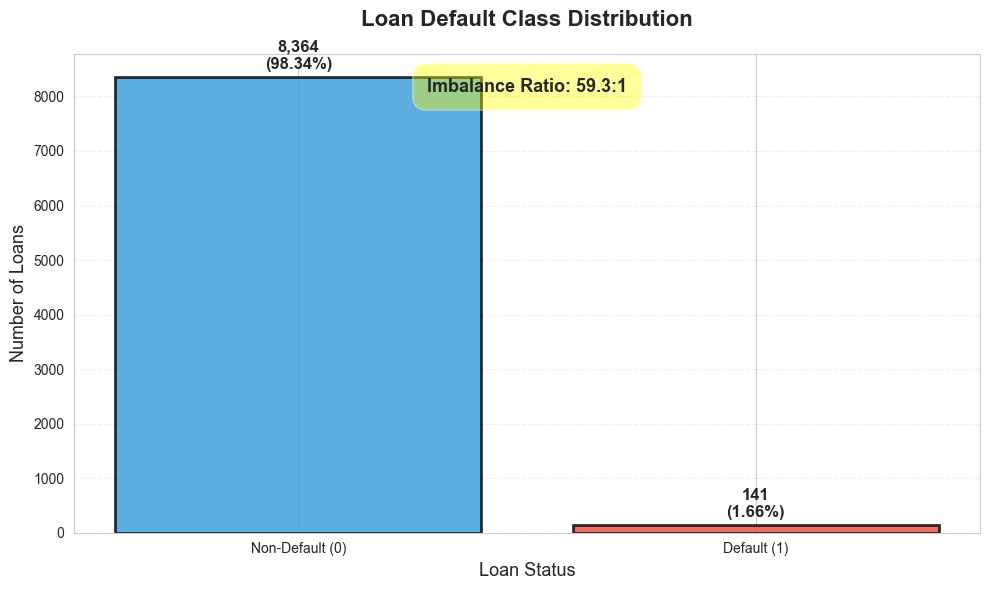


Class Distribution:
Non-Default: 8,364 (98.34%)
Default: 141 (1.66%)
Imbalance Ratio: 59.32:1


In [205]:
# Simple, clean single visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Get counts and percentages
counts = df_clean['is_default'].value_counts()
total = len(df_clean)
percentages = (counts / total * 100).round(2)

# Create bar chart
colors = ['#3498db', '#e74c3c']
bars = ax.bar(['Non-Default (0)', 'Default (1)'], counts.values, 
              color=colors, edgecolor='black', linewidth=2, alpha=0.8)

# Add labels
ax.set_title('Loan Default Class Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Number of Loans', fontsize=13)
ax.set_xlabel('Loan Status', fontsize=13)

# Add count and percentage labels on bars
for i, (bar, count, pct) in enumerate(zip(bars, counts.values, percentages.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + total*0.01,
            f'{count:,}\n({pct:.2f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add imbalance ratio annotation
ratio = counts[0] / counts[1]
ax.text(0.5, 0.95, f'Imbalance Ratio: {ratio:.1f}:1', 
        transform=ax.transAxes, ha='center', va='top',
        fontsize=13, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='yellow', alpha=0.4))

# Add grid for readability
ax.yaxis.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# Print summary
print(f"\nClass Distribution:")
print(f"Non-Default: {counts[0]:,} ({percentages[0]:.2f}%)")
print(f"Default: {counts[1]:,} ({percentages[1]:.2f}%)")
print(f"Imbalance Ratio: {ratio:.2f}:1")

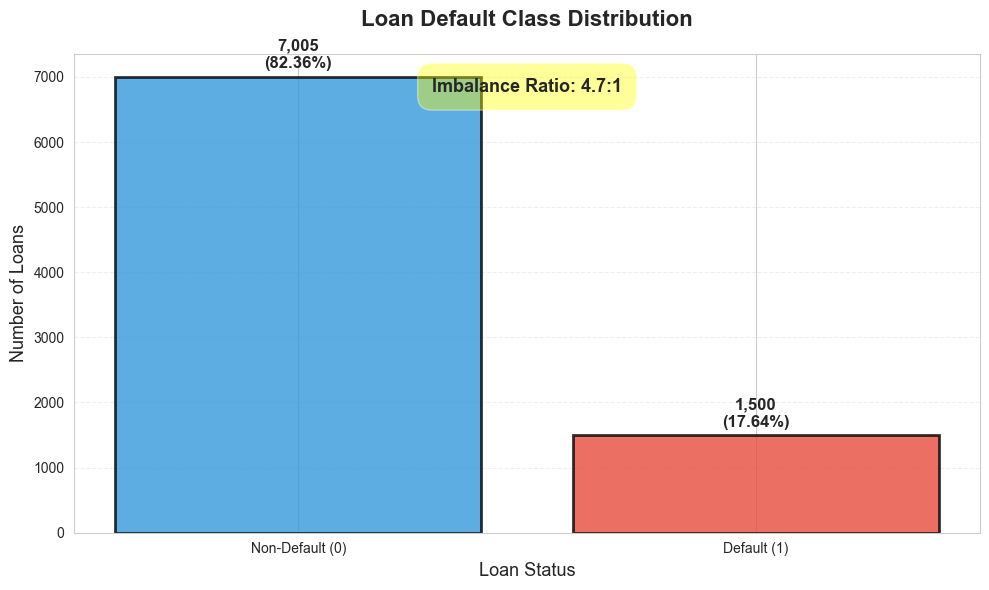


Class Distribution:
Non-Default: 7,005 (82.36%)
Default: 1,500 (17.64%)
Imbalance Ratio: 4.67:1


In [206]:
# Checking the imbalace ratio in loan grade
# Simple, clean single visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Get counts and percentages
counts = df_clean['grade'].value_counts()
total = len(df_clean)
percentages = (counts / total * 100).round(2)

# Create bar chart
colors = ['#3498db', '#e74c3c']
bars = ax.bar(['Non-Default (0)', 'Default (1)'], counts.values, 
              color=colors, edgecolor='black', linewidth=2, alpha=0.8)

# Add labels
ax.set_title('Loan Default Class Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Number of Loans', fontsize=13)
ax.set_xlabel('Loan Status', fontsize=13)

# Add count and percentage labels on bars
for i, (bar, count, pct) in enumerate(zip(bars, counts.values, percentages.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + total*0.01,
            f'{count:,}\n({pct:.2f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add imbalance ratio annotation
ratio = counts[0] / counts[1]
ax.text(0.5, 0.95, f'Imbalance Ratio: {ratio:.1f}:1', 
        transform=ax.transAxes, ha='center', va='top',
        fontsize=13, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='yellow', alpha=0.4))

# Add grid for readability
ax.yaxis.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# Print summary
print(f"\nClass Distribution:")
print(f"Non-Default: {counts[0]:,} ({percentages[0]:.2f}%)")
print(f"Default: {counts[1]:,} ({percentages[1]:.2f}%)")
print(f"Imbalance Ratio: {ratio:.2f}:1")

Due to the highly imbalance ratio of loan status, default is less than 2%, loan status will be used for my non default and default selection.

In [207]:
# drop the loan status converted to target
df_clean.drop(columns= ['is_default'], inplace = True)

In [208]:
# create a new target variable
df_clean['loan_grade_status'] = df_clean['grade']

In [209]:
# Summary statistics for numerical features
numerical_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print("Summary Statistics for Numerical Features:")
df_clean[numerical_features].describe().T

Summary Statistics for Numerical Features:


,count,mean,std,min,25%,50%,75%,max
emp_length,7890.0,5.882636,3.711236,0.000000,2.000000,6.00,10.00,1.000000e+01
annual_income,8505.0,82321.917529,67064.764552,5235.000000,48000.000000,68200.00,100000.00,2.300000e+06
debt_to_income,8505.0,17.339407,8.756774,0.000000,10.720000,16.79,23.38,3.999000e+01
delinq_2y,8505.0,0.216696,0.692626,0.000000,0.000000,0.00,0.00,1.300000e+01
earliest_credit_line,8505.0,2001.434450,7.743945,1963.000000,1998.000000,2003.00,2006.00,2.015000e+03
inquiries_last_12m,8505.0,1.960847,2.364582,0.000000,0.000000,1.00,3.00,2.900000e+01
total_credit_lines,8505.0,22.677366,11.925967,2.000000,14.000000,21.00,29.00,8.700000e+01
open_credit_lines,8505.0,11.452322,5.914916,0.000000,7.000000,10.00,15.00,5.100000e+01
total_credit_limit,8505.0,175983.150617,186210.230164,0.000000,49000.000000,105538.00,254999.00,3.386034e+06
total_credit_utilized,8505.0,49921.791182,53885.474379,0.000000,18703.000000,35446.00,63235.00,9.424560e+05


<Figure size 1200x600 with 0 Axes>

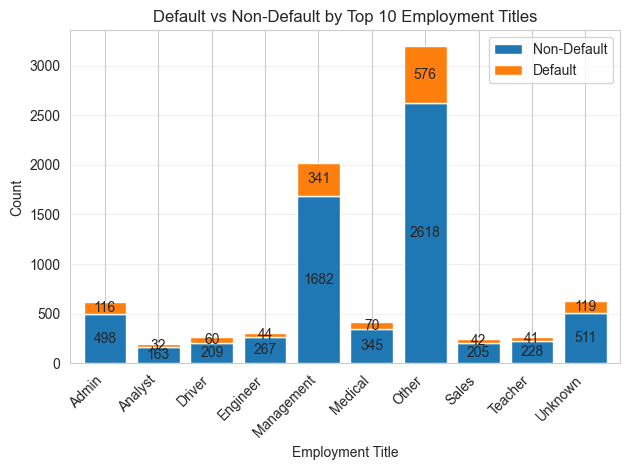


Employment Title Statistics:
loan_grade_status     0    1
emp_category                
Admin               498  116
Analyst             163   32
Driver              209   60
Engineer            267   44
Management         1682  341
Medical             345   70
Other              2618  576
Sales               205   42
Teacher             228   41
Unknown             511  119


In [210]:
# Get top 10 employment titles by frequency
top_10_titles = df_clean.groupby('emp_category').size().sort_values(ascending=False).head(10).index

# Create a dataframe with default/non-default counts for these titles
plot_data = df_clean[df_clean['emp_category'].isin(top_10_titles)].groupby(['emp_category', 'loan_grade_status']).size().unstack()

# Create the stacked bar plot
plt.figure(figsize=(12, 6))
ax = plot_data.plot(kind='bar', stacked=True, 
                    color=['tab:blue', 'tab:orange'],
                    width=0.8)

plt.title('Default vs Non-Default by Top 10 Employment Titles')
plt.xlabel('Employment Title')
plt.ylabel('Count')
plt.legend(['Non-Default', 'Default'])
plt.xticks(rotation=45, ha='right')

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='center')

plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

# Print the statistics
print("\nEmployment Title Statistics:")
print(plot_data)

<Figure size 1200x600 with 0 Axes>

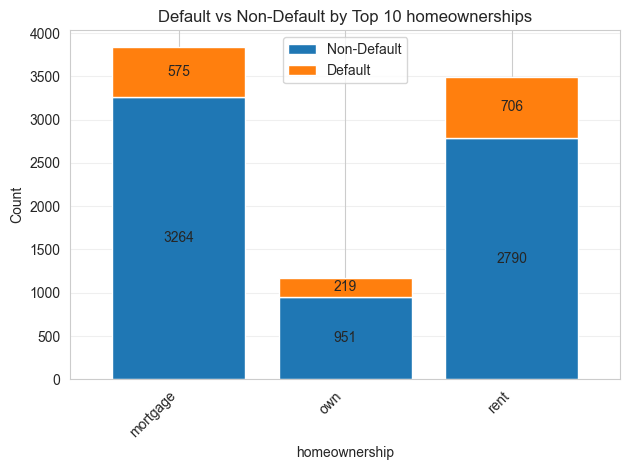

In [211]:
# Get top 10 employment titles by homeownership
top_10_titles = df_clean.groupby('homeownership').size().sort_values(ascending=False).head(10).index

# Create a dataframe with default/non-default counts for these titles
plot_data = df_clean[df_clean['homeownership'].isin(top_10_titles)].groupby(['homeownership', 'loan_grade_status']).size().unstack()

# Create the stacked bar plot
plt.figure(figsize=(12, 6))
ax = plot_data.plot(kind='bar', stacked=True, 
                    color=['tab:blue', 'tab:orange'],
                    width=0.8)

plt.title('Default vs Non-Default by Top 10 homeownerships')
plt.xlabel('homeownership')
plt.ylabel('Count')
plt.legend(['Non-Default', 'Default'])
plt.xticks(rotation=45, ha='right')

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='center')

plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

<Figure size 1200x600 with 0 Axes>

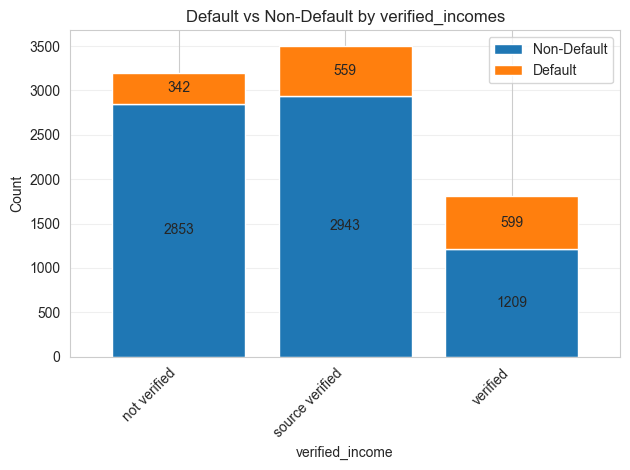

In [212]:
# Get top 10 employment titles by verified_income
top_10_titles = df_clean.groupby('verified_income').size().sort_values(ascending=False).head(10).index

# Create a dataframe with default/non-default counts for these titles
plot_data = df_clean[df_clean['verified_income'].isin(top_10_titles)].groupby(['verified_income', 'loan_grade_status']).size().unstack()

# Create the stacked bar plot
plt.figure(figsize=(12, 6))
ax = plot_data.plot(kind='bar', stacked=True, 
                    color=['tab:blue', 'tab:orange'],
                    width=0.8)

plt.title('Default vs Non-Default by verified_incomes')
plt.xlabel('verified_income')
plt.ylabel('Count')
plt.legend(['Non-Default', 'Default'])
plt.xticks(rotation=45, ha='right')

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='center')

plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

- Borrowers whose income sources has been verified get more loan and alos default the most.

<Figure size 1200x600 with 0 Axes>

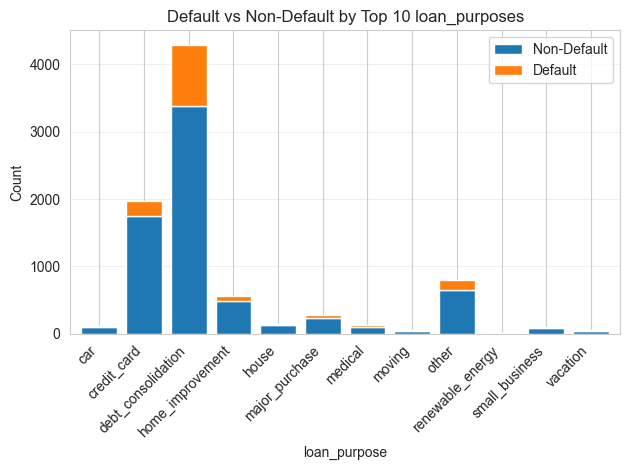

In [213]:
# Get top 10 employment titles by loan_purpose
top_10_titles = df_clean.groupby('loan_purpose').size().sort_values(ascending=False).index

# Create a dataframe with default/non-default counts for these titles
plot_data = df_clean[df_clean['loan_purpose'].isin(top_10_titles)].groupby(['loan_purpose', 'loan_grade_status']).size().unstack()

# Create the stacked bar plot
plt.figure(figsize=(12, 6))
ax = plot_data.plot(kind='bar', stacked=True, 
                    color=['tab:blue', 'tab:orange'],
                    width=0.8)

plt.title('Default vs Non-Default by Top 10 loan_purposes')
plt.xlabel('loan_purpose')
plt.ylabel('Count')
plt.legend(['Non-Default', 'Default'])
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

- Borrowers who want to consolidate their loan borrow the most in this group and alos default the most.

- They are more people in the current loan holders who are defaulting.

<Figure size 1200x600 with 0 Axes>

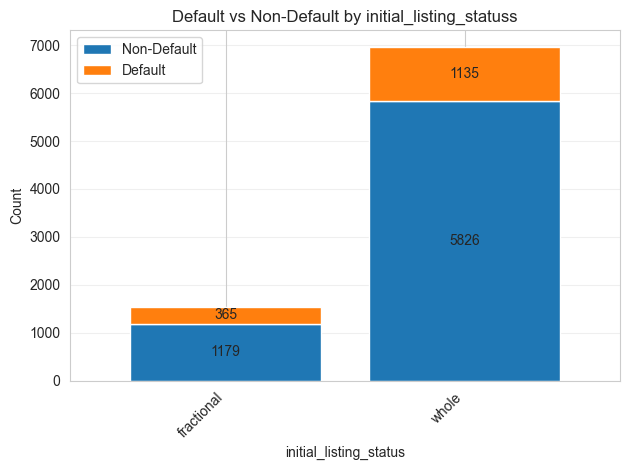

In [214]:
# Get top 10 employment titles by initial_listing_status
top_10_titles = df_clean.groupby('initial_listing_status').size().sort_values(ascending=False).head(10).index

# Create a dataframe with default/non-default counts for these titles
plot_data = df_clean[df_clean['initial_listing_status'].isin(top_10_titles)].groupby(['initial_listing_status', 'loan_grade_status']).size().unstack()

# Create the stacked bar plot
plt.figure(figsize=(12, 6))
ax = plot_data.plot(kind='bar', stacked=True, 
                    color=['tab:blue', 'tab:orange'],
                    width=0.8)

plt.title('Default vs Non-Default by initial_listing_statuss')
plt.xlabel('initial_listing_status')
plt.ylabel('Count')
plt.legend(['Non-Default', 'Default'])
plt.xticks(rotation=45, ha='right')

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='center')

plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

- Borrowers who got their loan from one lenders default the most, even though they get more loans too

<Figure size 1200x600 with 0 Axes>

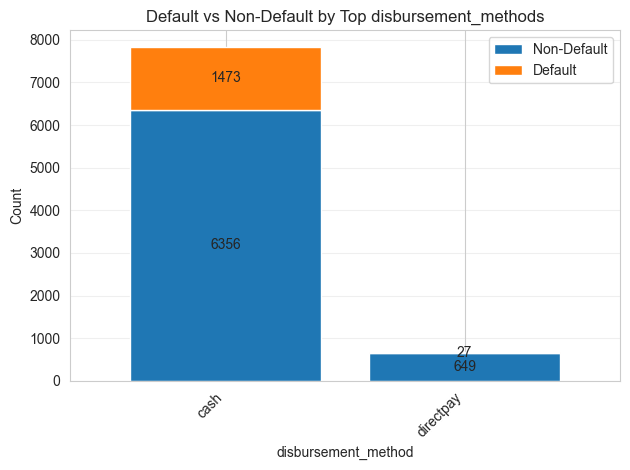

In [215]:
# Get top 10 disbursement_method by defaults status
top_10_titles = df_clean.groupby('disbursement_method').size().sort_values(ascending=False).head(10).index

# Create a dataframe with default/non-default counts for these titles
plot_data = df_clean[df_clean['disbursement_method'].isin(top_10_titles)].groupby(['disbursement_method', 'loan_grade_status']).size().unstack()

# Create the stacked bar plot
plt.figure(figsize=(12, 6))
ax = plot_data.plot(kind='bar', stacked=True, 
                    color=['tab:blue', 'tab:orange'],
                    width=0.8)

plt.title('Default vs Non-Default by Top disbursement_methods')
plt.xlabel('disbursement_method')
plt.ylabel('Count')
plt.legend(['Non-Default', 'Default'])
plt.xticks(rotation=45, ha='right')

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='center')

plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

EDA on numeric column

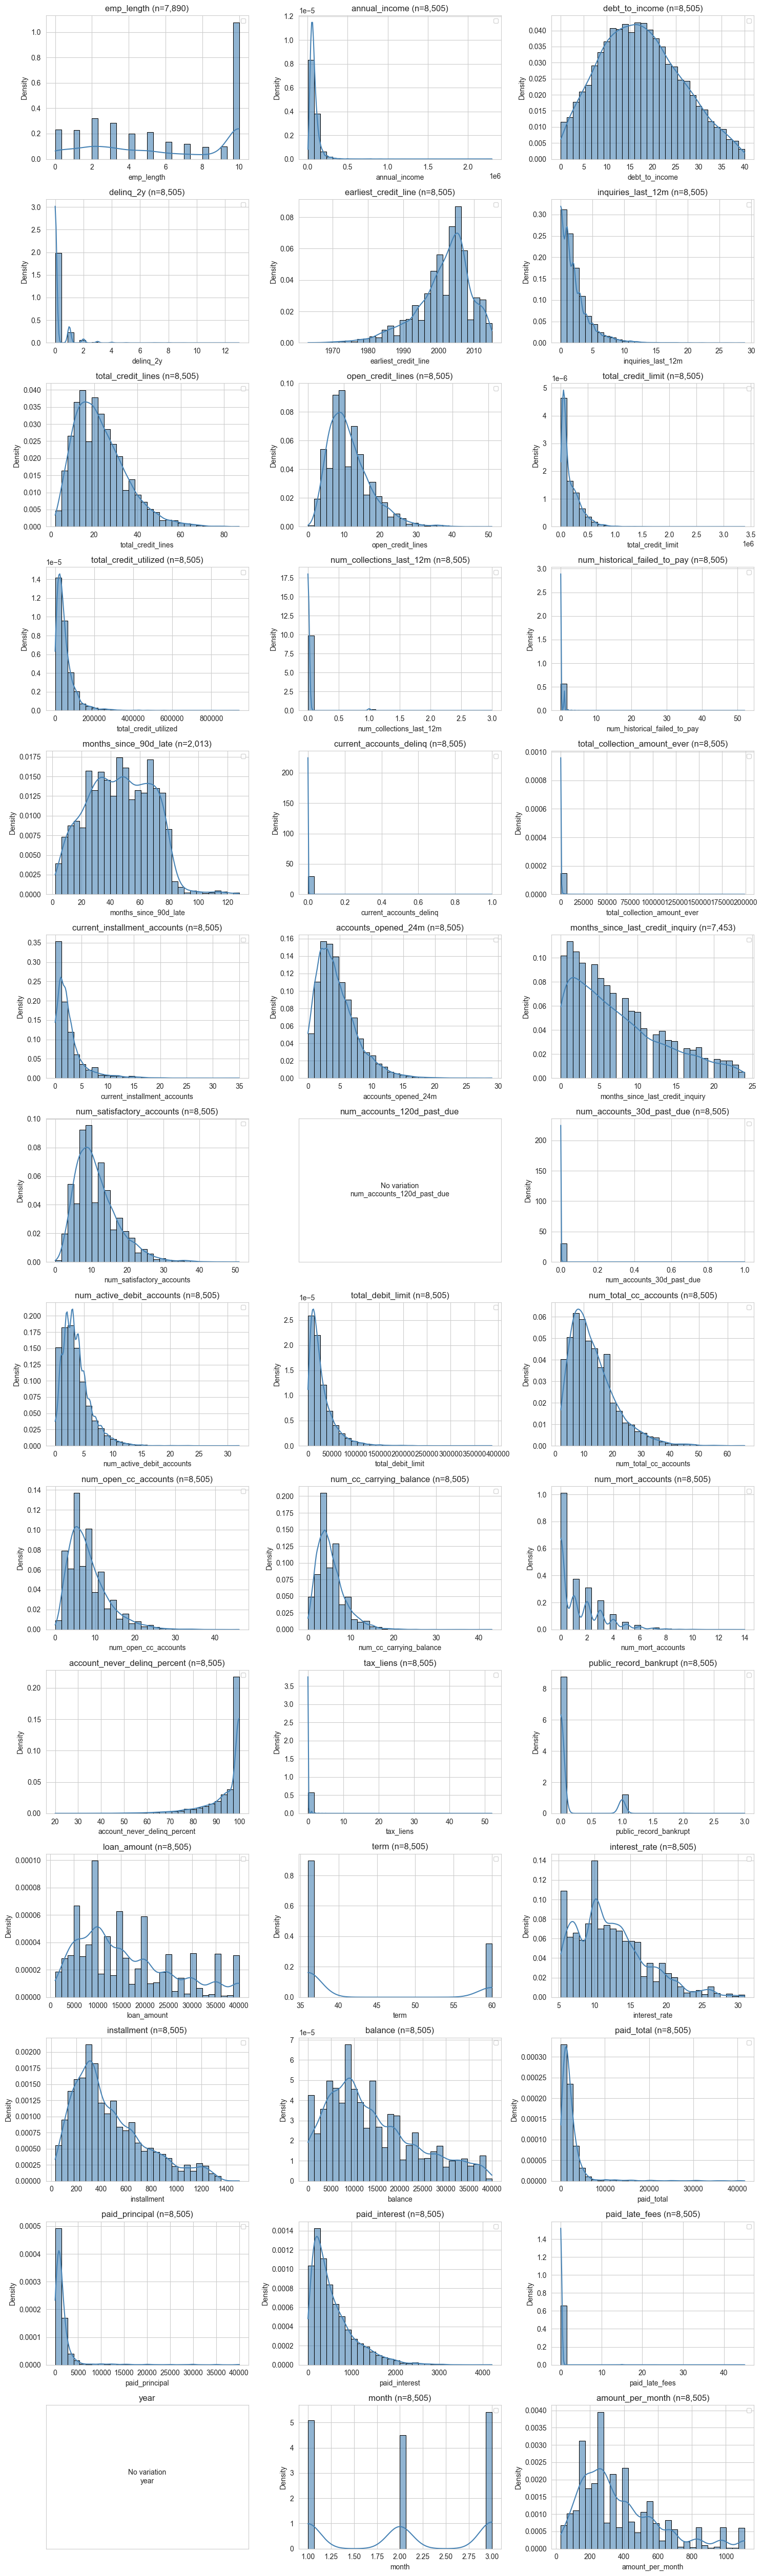

In [216]:
import math
from scipy.stats import skew

# Combined histogram + KDE plots for numeric_cols
numeric_cols = df_clean.select_dtypes('number')
# Use the existing df_filtered and numeric_cols from the notebook
cols = [c for c in numeric_cols if c in df_clean.columns]
if not cols:
    raise ValueError("No numeric columns found in df_clean from variable `numeric_cols`.")

n = len(cols)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 3.6))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    s = df_clean[col].dropna()

    if s.empty or s.nunique() <= 1:
        ax.text(0.5, 0.5, f"No variation\n{col}", ha='center', va='center')
        ax.set_title(col)
        ax.set_xticks([])
        ax.set_yticks([])
        continue

    # Plot histogram with KDE (density)
    sns.histplot(s, bins=30, stat='density', kde=True,
                 color='steelblue', edgecolor='k', alpha=0.6, ax=ax)

    # Add mean and median lines
   

 

    ax.set_title(f"{col} (n={len(s):,})")
    ax.legend(loc='upper right', fontsize=8)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [217]:
df_clean.loan_grade_status = df_clean.loan_grade_status.astype(int)

While negative correlations were observed, features will be removed or retained based on the fisher score.

In [218]:
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

In [219]:
# Replace missing values: mean for numeric columns, mode for categorical columns

# Fill numeric columns with mean
for col in numeric_cols:
    mean_val = df_clean[col].mean()
    df_clean[col] = df_clean[col].fillna(mean_val)
    print(f"Filled {col} NaN values with mean: {mean_val:.2f}")


# Fill categorical columns with mode (or 'unknown' if no mode exists)
for col in categorical_cols:
    mode_series = df_clean[col].mode()
    if not mode_series.empty:
        mode_val = mode_series.iloc[0]  # Get the first mode value
        df_clean[col] = df_clean[col].fillna(mode_val)
        print(f"Filled {col} NaN values with mode: '{mode_val}'")
    else:
        # Fallback to 'unknown' if no mode exists
        df_clean[col] = df_clean[col].fillna('unknown')
        print(f"No mode found for {col}, filled NaN values with 'unknown'")

# Check for remaining missing values
missing_after = df_clean.isnull().sum().sum()
print(f"\nTotal missing values after imputation: {missing_after}")

# Optional: Check original df as well
missing_original = df.isnull().sum().sum()
print(f"Total missing values in original df: {missing_original}")

# Show final shape
print(f"Final dataframe shape: {df_clean.shape}")

Filled emp_length NaN values with mean: 5.88
Filled annual_income NaN values with mean: 82321.92
Filled debt_to_income NaN values with mean: 17.34
Filled delinq_2y NaN values with mean: 0.22
Filled earliest_credit_line NaN values with mean: 2001.43
Filled inquiries_last_12m NaN values with mean: 1.96
Filled total_credit_lines NaN values with mean: 22.68
Filled open_credit_lines NaN values with mean: 11.45
Filled total_credit_limit NaN values with mean: 175983.15
Filled total_credit_utilized NaN values with mean: 49921.79
Filled num_collections_last_12m NaN values with mean: 0.02
Filled num_historical_failed_to_pay NaN values with mean: 0.17
Filled months_since_90d_late NaN values with mean: 46.09
Filled current_accounts_delinq NaN values with mean: 0.00
Filled total_collection_amount_ever NaN values with mean: 189.39
Filled current_installment_accounts NaN values with mean: 2.63
Filled accounts_opened_24m NaN values with mean: 4.43
Filled months_since_last_credit_inquiry NaN values wit

In [220]:
# Detect outlier columns using IQR method
def detect_outlier_columns(df, factor=1.5):
    """
    Detect columns with outliers using IQR method.
    
    Parameters:
    df (DataFrame): Input dataframe
    factor (float): IQR multiplier for outlier detection (default 1.5)
    
    Returns:
    list: List of column names with outliers
    """
    outlier_cols = []
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if col == 'is_default':  # Skip target column
            continue
            
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        # Check if there are outliers
        outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        if outliers.sum() > 0:
            outlier_cols.append(col)
    
    return outlier_cols

# Detect outlier columns
outlier_cols = detect_outlier_columns(df_clean)
print(f"Detected outlier columns: {outlier_cols}")

Detected outlier columns: ['annual_income', 'delinq_2y', 'earliest_credit_line', 'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines', 'total_credit_limit', 'total_credit_utilized', 'num_collections_last_12m', 'num_historical_failed_to_pay', 'months_since_90d_late', 'current_accounts_delinq', 'total_collection_amount_ever', 'current_installment_accounts', 'accounts_opened_24m', 'months_since_last_credit_inquiry', 'num_satisfactory_accounts', 'num_accounts_30d_past_due', 'num_active_debit_accounts', 'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts', 'num_cc_carrying_balance', 'num_mort_accounts', 'account_never_delinq_percent', 'tax_liens', 'public_record_bankrupt', 'interest_rate', 'installment', 'grade', 'balance', 'paid_total', 'paid_principal', 'paid_interest', 'paid_late_fees', 'amount_per_month', 'loan_grade_status']


In [221]:
import numpy as np

def winsorize_outliers(df, column, lower_percentile=0.05, upper_percentile=0.95):
    """
    Winsorize outliers in a column by capping at specified percentiles.
    
    Parameters:
    df (DataFrame): Input dataframe
    column (str): Column name to process
    lower_percentile (float): Lower percentile for capping (default 0.05)
    upper_percentile (float): Upper percentile for capping (default 0.95)
    
    Returns:
    DataFrame: Dataframe with outliers winsorized
    """
    lower_bound = df_clean[column].quantile(lower_percentile)
    upper_bound = df_clean[column].quantile(upper_percentile)
    
    df[column] = np.where(df_clean[column] < lower_bound, lower_bound, 
                         np.where(df_clean[column] > upper_bound, upper_bound, df_clean[column]))
    
    print(f"Winsorized {column} at {lower_percentile*100}th and {upper_percentile*100}th percentiles")
    print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
    
    return df

# Example usage: Apply to detected outlier columns (excluding target column)
print("Applying winsorization to outlier columns...")
target_column = 'loan_grade_status'

for col in outlier_cols:
    if col != target_column:  # Skip the target column
        df_clean = winsorize_outliers(df_clean, col)
    else:
        print(f"Skipping target column: {col}")

print(f"\nFinal dataframe shape after winsorization: {df_clean.shape}")

Applying winsorization to outlier columns...
Winsorized annual_income at 5.0th and 95.0th percentiles
Lower bound: 28000.00, Upper bound: 180000.00
Winsorized delinq_2y at 5.0th and 95.0th percentiles
Lower bound: 0.00, Upper bound: 1.00
Winsorized earliest_credit_line at 5.0th and 95.0th percentiles
Lower bound: 1986.00, Upper bound: 2012.00
Winsorized inquiries_last_12m at 5.0th and 95.0th percentiles
Lower bound: 0.00, Upper bound: 7.00
Winsorized total_credit_lines at 5.0th and 95.0th percentiles
Lower bound: 7.00, Upper bound: 45.00
Winsorized open_credit_lines at 5.0th and 95.0th percentiles
Lower bound: 4.00, Upper bound: 23.00
Winsorized total_credit_limit at 5.0th and 95.0th percentiles
Lower bound: 17000.00, Upper bound: 527677.00
Winsorized total_credit_utilized at 5.0th and 95.0th percentiles
Lower bound: 4606.60, Upper bound: 140264.40
Winsorized num_collections_last_12m at 5.0th and 95.0th percentiles
Lower bound: 0.00, Upper bound: 0.00
Winsorized num_historical_failed_t

In [222]:
# create a dataframe for my segmenation
df_seg = df_clean.copy()

In [223]:
# drop features that can cause leakage and used for feature engineering
#for interest_rate, this could have been computed after reviewing borrowers info and computed due to this
leakage_columns = ['months_since_last_delinq','interest_rate' 'loan_status',
                       'issue_month','state','delinq_2y', 'months_since_last_delinq',
# Remove columns that will lead to leakage and columns that will not be used for analysis early to avoid leakage
    'paid_total',
    'emp_length',
    'num_accounts_120d_past_due',
     'grade', 
    'balance',
    'last_pymnt_amnt',
    'total_collection_amount_ever',
    'account_never_delinq_percent',
    'public_record_bankrupt',
    'paid_principal',
    'paid_interest',
    'paid_late_fees',
    'interest_rate',
    'loan_amount',
    'installment',
    'state',
    'num_collections_last_12m',
    # too much cardinality in subgrade, we have grade already 
    'sub_grade',
]
df_clean = df_clean.drop(columns=[col for col in leakage_columns if col in df_clean.columns])
df_clean.shape

(8505, 37)

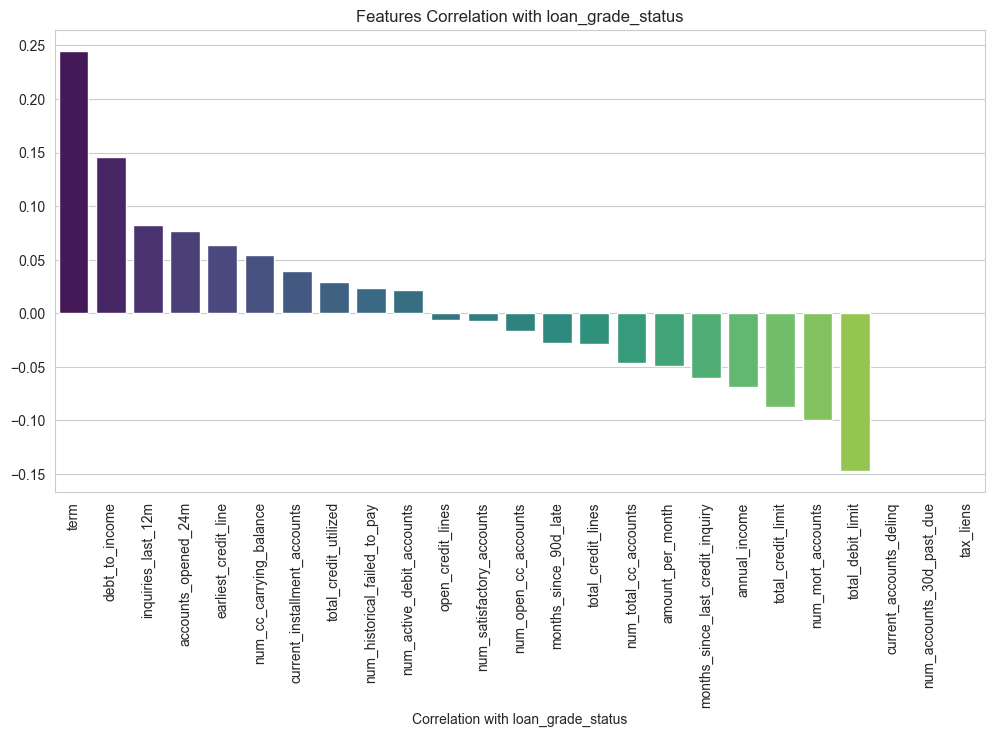

term                                0.244817
debt_to_income                      0.145849
inquiries_last_12m                  0.082474
accounts_opened_24m                 0.077036
earliest_credit_line                0.064084
num_cc_carrying_balance             0.054417
current_installment_accounts        0.039083
total_credit_utilized               0.028910
num_historical_failed_to_pay        0.023289
num_active_debit_accounts           0.021856
open_credit_lines                  -0.006810
num_satisfactory_accounts          -0.007112
num_open_cc_accounts               -0.016672
months_since_90d_late              -0.027823
total_credit_lines                 -0.028622
num_total_cc_accounts              -0.046327
amount_per_month                   -0.049034
months_since_last_credit_inquiry   -0.060332
annual_income                      -0.068788
total_credit_limit                 -0.087616
num_mort_accounts                  -0.100216
total_debit_limit                  -0.147337
current_ac

In [224]:
target  = 'loan_grade_status'

corr_df = df_clean.copy() 


# correlation with y
correlation_with_loan_condition = corr_df.select_dtypes(include=['int64', 'float64']).corr()[target]
sorted_correlation = correlation_with_loan_condition.drop(target).sort_values(ascending=False)

# plot
plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_correlation.index, y=sorted_correlation.values, palette='viridis')
plt.xlabel('Correlation with {}'.format(target))
plt.title('Features Correlation with {}'.format(target))
plt.xticks(rotation=90)
plt.show()
print(sorted_correlation)

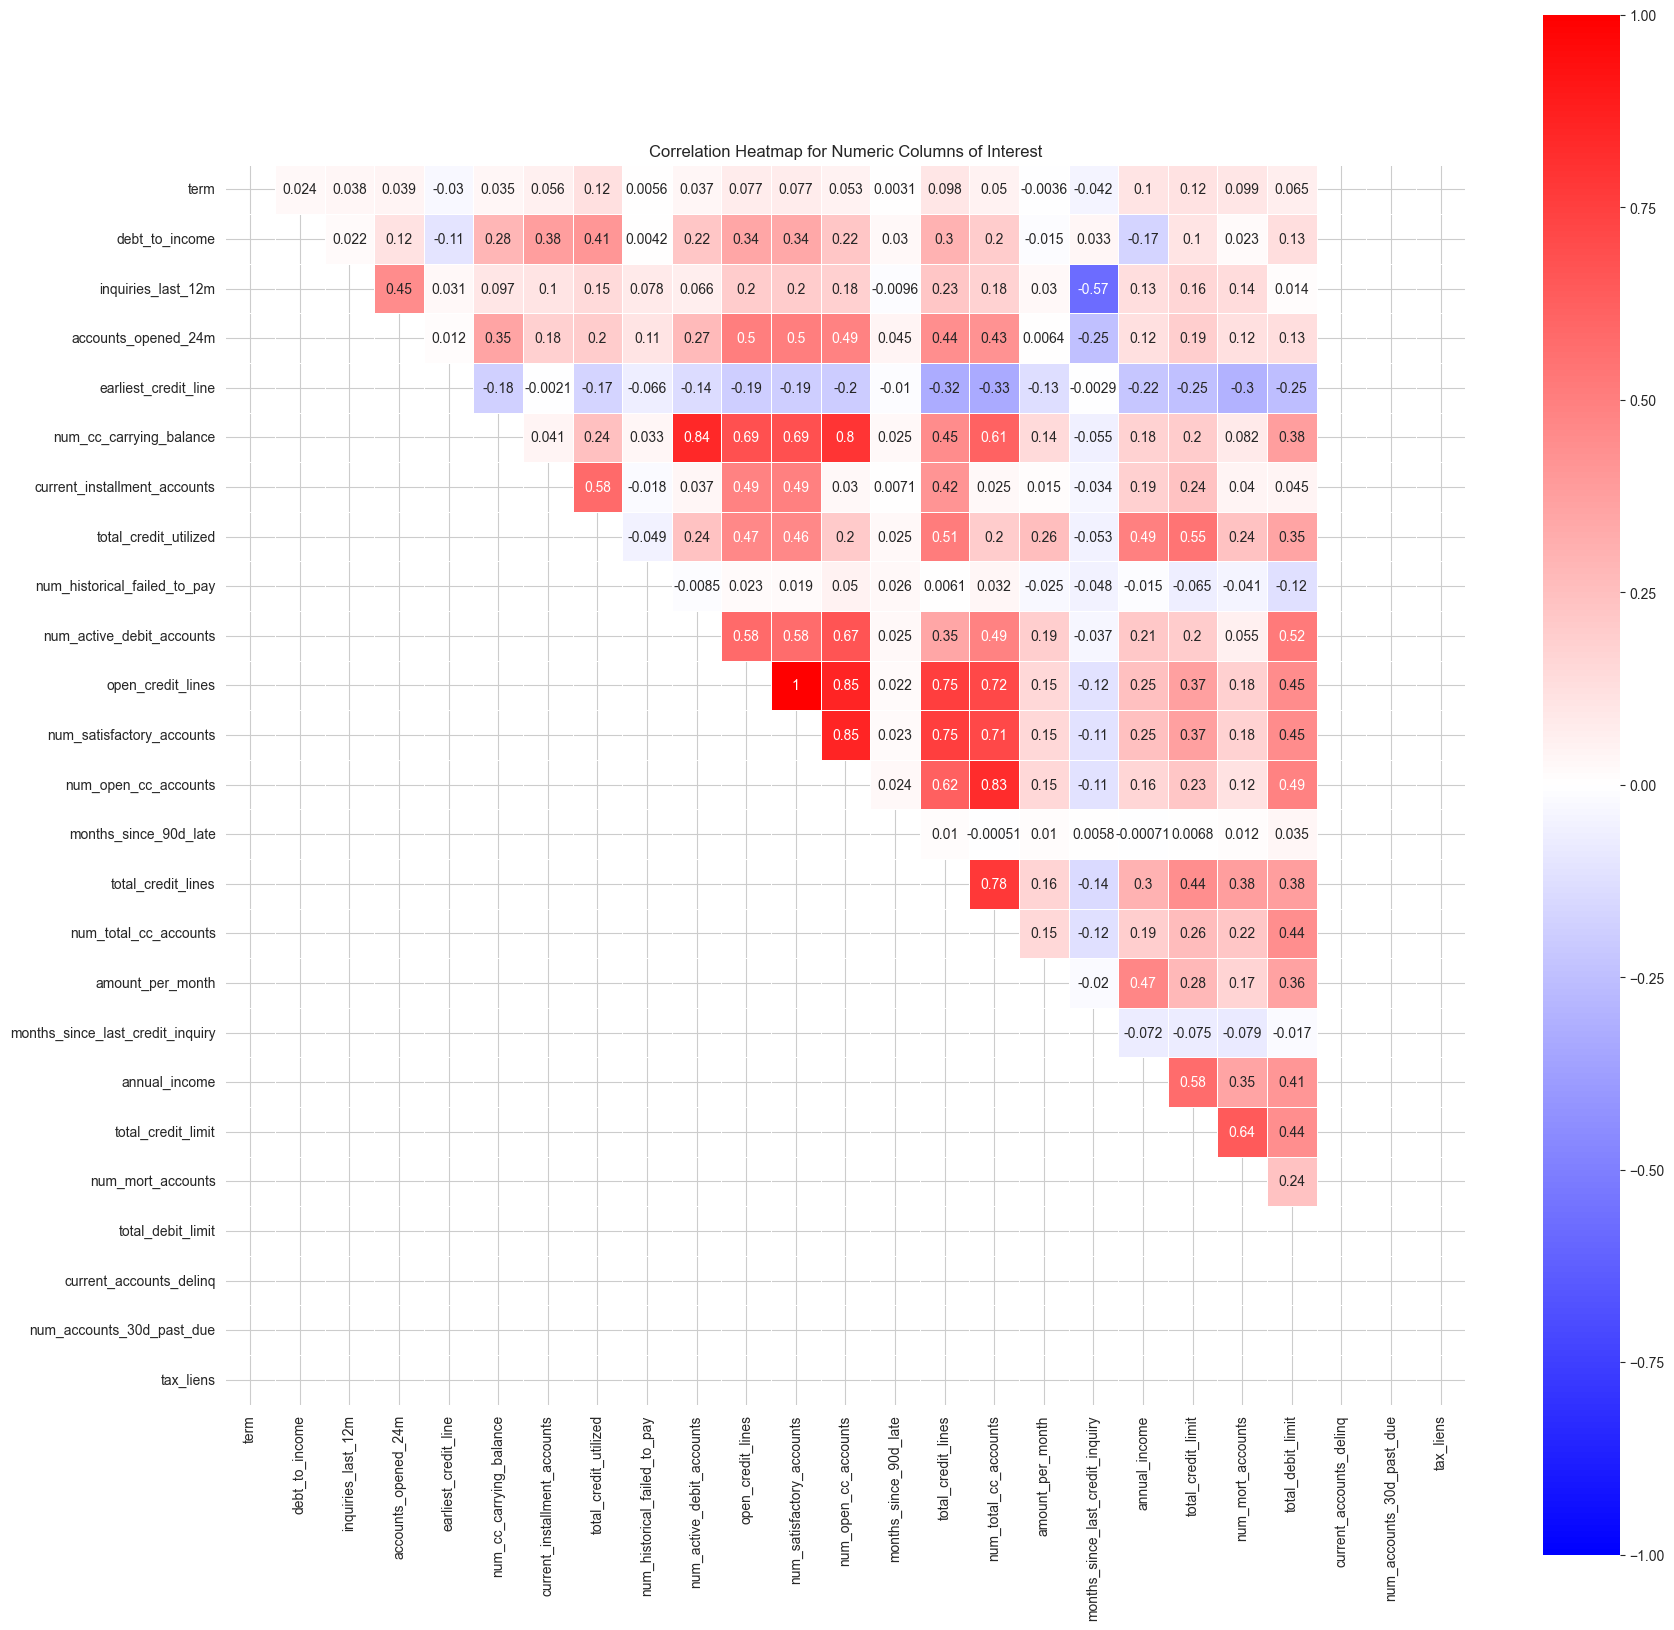

In [225]:
# Select the variables with the highest correlation with the dependent variable and explore the correlation between them
top_variables = sorted_correlation.abs().index.tolist()

plt.figure(figsize=(20, 20))
correlation_matrix = corr_df = df_clean.copy() 
correlation_matrix = correlation_matrix[top_variables].corr()
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, cmap='bwr', vmin=-1, vmax=1, square=True, linewidths=0.5, mask=mask)
plt.title('Correlation Heatmap for Numeric Columns of Interest')
plt.show()

In [226]:
correlation_matrix = corr_df[top_variables].corr()
# Identify highly correlated pairs
high_corr_pairs = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            high_corr_pairs.add((colname_i, colname_j))

# Print the highly correlated pairs
print("Highly correlated pairs (absolute correlation >= 0.8):")
for pair in high_corr_pairs:
    print(pair, correlation_matrix.loc[pair[0], pair[1]])

Highly correlated pairs (absolute correlation >= 0.8):
('num_active_debit_accounts', 'num_cc_carrying_balance') 0.8403051556257798
('num_open_cc_accounts', 'num_satisfactory_accounts') 0.8532025340019836
('num_satisfactory_accounts', 'open_credit_lines') 0.9993873989454798
('num_total_cc_accounts', 'num_open_cc_accounts') 0.8270303613514729
('num_open_cc_accounts', 'open_credit_lines') 0.85375383492609


In [227]:
# drop highly correlated columns to avoid multicollinearity
for pair in high_corr_pairs:
    col1, col2 = pair
    if col2 in df_clean.columns:
        df_clean_outliers = df_clean.drop(columns=[col2])
        print(f"Dropped column {col2} due to high correlation with {col1}")

Dropped column num_cc_carrying_balance due to high correlation with num_active_debit_accounts
Dropped column num_satisfactory_accounts due to high correlation with num_open_cc_accounts
Dropped column open_credit_lines due to high correlation with num_satisfactory_accounts
Dropped column num_open_cc_accounts due to high correlation with num_total_cc_accounts
Dropped column open_credit_lines due to high correlation with num_open_cc_accounts


In [228]:
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

In [229]:
# create a new dataframe from the clean dataframe
df_model = df_clean.copy()

In [230]:
from sklearn.metrics import make_scorer
# ### Custom Metric: Kolmogorov-Smirnov (KS) Score
#
# This is a key metric for credit scoring. It measures the maximum separation between the cumulative distribution functions (CDF) of good borrowers (class 0) and bad borrowers (class 1). A higher KS score (closer to 1) indicates better model discrimination.

# %%
def ks_score(y_true, y_pred_proba):
    """
    Calculates the Kolmogorov-Smirnov (KS) score.
    y_true: Array of true labels (0s and 1s)
    y_pred_proba: Array of predicted probabilities for the positive class (1)
    """
    # Combine true labels and predicted probabilities
    data = pd.DataFrame({'y_true': y_true, 'y_pred_proba': y_pred_proba})
    
    # Sort by predicted probability in descending order
    data = data.sort_values(by='y_pred_proba', ascending=False)
    
    # Calculate cumulative percentages
    # Ensure denominator is not zero if a class is missing (in a bad fold)
    total_good = (1 - data['y_true']).sum()
    total_bad = data['y_true'].sum()
    
    if total_good == 0 or total_bad == 0:
        return 0.0 # Cannot calculate KS if one class is missing
        
    data['cumulative_good'] = (1 - data['y_true']).cumsum() / total_good
    data['cumulative_bad'] = data['y_true'].cumsum() / total_bad
    
    # Find the maximum difference
    ks_value = (data['cumulative_bad'] - data['cumulative_good']).max()
    
    return ks_value

# Create an sklearn-compatible scorer
ks_scorer = make_scorer(ks_score, needs_proba=True)


In [231]:

# 1. Define Target and Features
TARGET = 'loan_grade_status' # Change to 'loan_status' for your data
X = df_model.drop(TARGET, axis=1)
y = df_model[TARGET]

# 2. Identify feature types
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"Target: {TARGET}")
print(f"Numeric Features: {numeric_features}")
print(f"Categorical Features: {categorical_features}")
print(f"\nClass Distribution:\n{y.value_counts(normalize=True)}")


Target: loan_grade_status
Numeric Features: ['annual_income', 'debt_to_income', 'earliest_credit_line', 'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines', 'total_credit_limit', 'total_credit_utilized', 'num_historical_failed_to_pay', 'months_since_90d_late', 'current_accounts_delinq', 'current_installment_accounts', 'accounts_opened_24m', 'months_since_last_credit_inquiry', 'num_satisfactory_accounts', 'num_accounts_30d_past_due', 'num_active_debit_accounts', 'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts', 'num_cc_carrying_balance', 'num_mort_accounts', 'tax_liens', 'term', 'year', 'month', 'amount_per_month']
Categorical Features: ['homeownership', 'verified_income', 'loan_purpose', 'application_type', 'loan_status', 'initial_listing_status', 'disbursement_method', 'emp_category', 'region']

Class Distribution:
loan_grade_status
0    0.823633
1    0.176367
Name: proportion, dtype: float64


In [232]:
from sklearn.feature_selection import SelectFromModel  # <-- added

# Create a stratified train/test split
# We will use cross-validation on X_train/y_train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")

# 1. Create the preprocessing transformer
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)



Training samples: 6804
Test samples: 1701


In [233]:


# 2. Define models to evaluate
models = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000, 
                                             class_weight='balanced'),
    'RandomForest': RandomForestClassifier(
        random_state=42, class_weight='balanced', n_jobs=-1,
        max_depth=10, min_samples_leaf=10
    ),
    'GradientBoosting': GradientBoostingClassifier(
        random_state=42, subsample=0.8, n_iter_no_change=10, validation_fraction=0.1
    ),
    'XGBoost': XGBClassifier(
        random_state=42, n_jobs=-1, eval_metric='logloss',
        learning_rate=0.1, max_depth=4, subsample=0.8, colsample_bytree=0.8
    )
}

# # --- NEW: Embedded feature selection with L1 Logistic Regression ---
# l1_selector = SelectFromModel(
#     LogisticRegression(
#         penalty='l1', solver='liblinear', class_weight='balanced',
#         max_iter=1000, random_state=42
#     ),
#     threshold='median'  # keep features with |coef| >= median importance
# )

# 3. Define the pipelines
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])


In [234]:




# Step 4: Run Cross-Validation Evaluation
# We now loop through our 4 defined pipelines and evaluate them using 5-fold stratified cross-validation. This gives us a robust estimate of their performance on unseen data.

# %%
def evaluate_pipelines(pipelines, X, y):
    """Runs stratified cross-validation on all pipelines and returns a results DataFrame."""
    
    # Define the cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define the scorers dictionary
    scoring = {
        'AUC': 'roc_auc',
       'KS_Score': ks_scorer
    }
    
    results = []
    
    print("Starting cross-validation...")
    
    for name, pipe in pipelines.items():
        print(f"Evaluating: {name}")
        
        # Run cross-validation
        scores = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        
        # Store results
        result_row = {
            'Model': name,
            'AUC_Mean': np.mean(scores['test_AUC']),
            # 'F1_Mean': np.mean(scores['test_F1_Score']),
            'KS_Score_Mean': np.mean(scores['test_KS_Score']),
            # 'Fit_Time_Mean': np.mean(scores['fit_time'])
        }
        results.append(result_row)
    
    print("Cross-validation complete.")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results).sort_values(by='AUC_Mean', ascending=False)
    return results_df


Starting cross-validation...
Evaluating: LogisticRegression


Evaluating: RandomForest
Evaluating: GradientBoosting
Evaluating: XGBoost
Cross-validation complete.
Fitting all 4 models on full training data...
... fitting LogisticRegression
... fitting RandomForest
... fitting GradientBoosting
... fitting XGBoost
All models fitted.

--- Detailed Analysis for: LogisticRegression ---

--- 1. Generalization Check ---


,Metric,Training Set,Test Set,Drop-off
0,KS Score,0.5195,0.4747,0.0448
1,AUC,0.8354,0.8027,0.0327
2,PR-AUC,0.5284,0.4786,0.0498



--- 2. Confusion Matrix & Classification Report (Test Set) ---
              precision    recall  f1-score   support

    Paid (0)       0.93      0.73      0.81      1401
 Default (1)       0.37      0.74      0.49       300

    accuracy                           0.73      1701
   macro avg       0.65      0.73      0.65      1701
weighted avg       0.83      0.73      0.76      1701



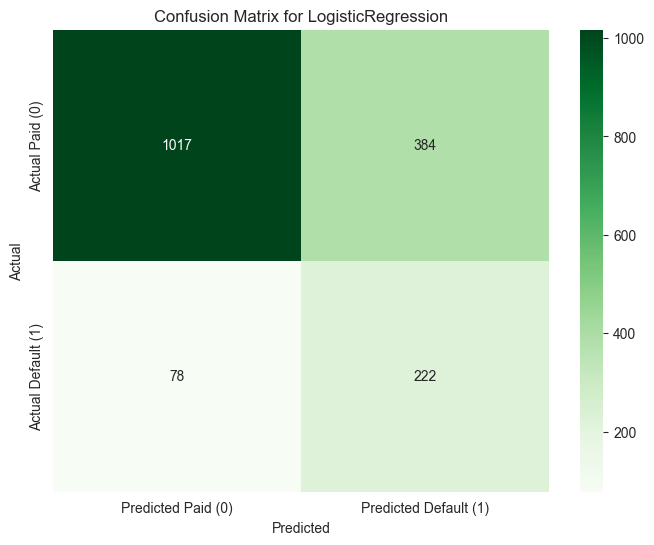


--- Detailed Analysis for: RandomForest ---

--- 1. Generalization Check ---


,Metric,Training Set,Test Set,Drop-off
0,KS Score,0.7394,0.4618,0.2776
1,AUC,0.9403,0.8027,0.1377
2,PR-AUC,0.7702,0.4934,0.2767



--- 2. Confusion Matrix & Classification Report (Test Set) ---
              precision    recall  f1-score   support

    Paid (0)       0.90      0.83      0.87      1401
 Default (1)       0.43      0.58      0.49       300

    accuracy                           0.79      1701
   macro avg       0.67      0.71      0.68      1701
weighted avg       0.82      0.79      0.80      1701



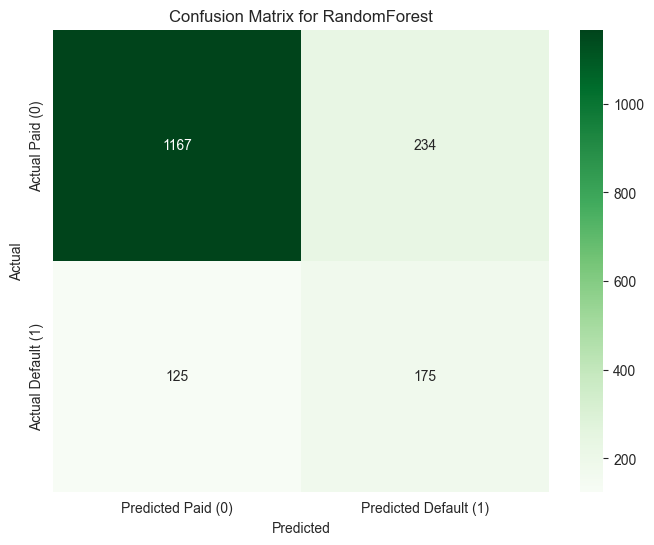


--- Detailed Analysis for: GradientBoosting ---

--- 1. Generalization Check ---


,Metric,Training Set,Test Set,Drop-off
0,KS Score,0.6270,0.5031,0.1239
1,AUC,0.8918,0.8268,0.0650
2,PR-AUC,0.6604,0.5340,0.1265



--- 2. Confusion Matrix & Classification Report (Test Set) ---
              precision    recall  f1-score   support

    Paid (0)       0.86      0.97      0.91      1401
 Default (1)       0.64      0.28      0.39       300

    accuracy                           0.84      1701
   macro avg       0.75      0.62      0.65      1701
weighted avg       0.82      0.84      0.82      1701



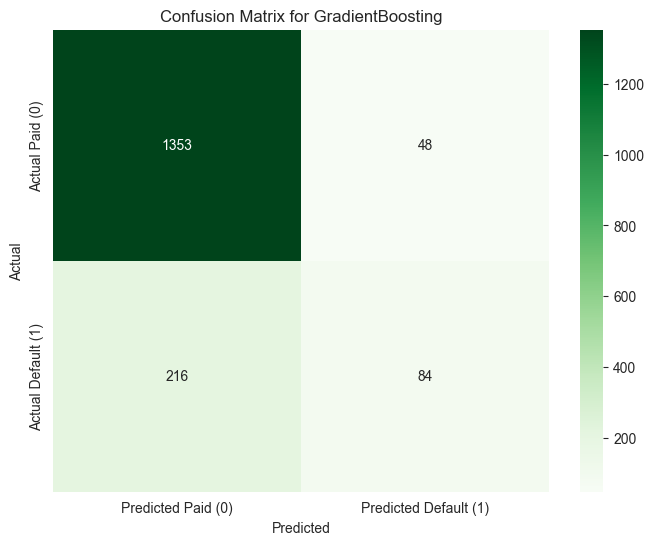


--- Detailed Analysis for: XGBoost ---

--- 1. Generalization Check ---


,Metric,Training Set,Test Set,Drop-off
0,KS Score,0.7080,0.5259,0.1821
1,AUC,0.9237,0.8275,0.0962
2,PR-AUC,0.7421,0.5338,0.2083



--- 2. Confusion Matrix & Classification Report (Test Set) ---
              precision    recall  f1-score   support

    Paid (0)       0.86      0.96      0.91      1401
 Default (1)       0.62      0.30      0.40       300

    accuracy                           0.84      1701
   macro avg       0.74      0.63      0.66      1701
weighted avg       0.82      0.84      0.82      1701



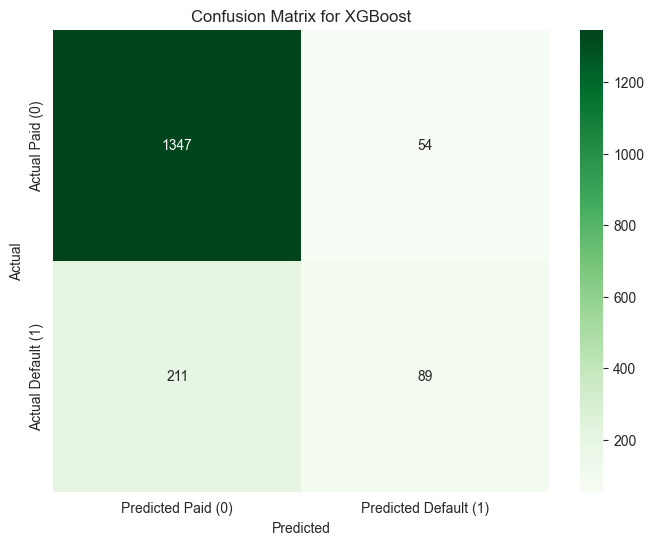

In [235]:

# Run the evaluation on the training data
cv_results_df = evaluate_pipelines(pipelines, X_train, y_train)


# Analyze Cross-Validation Results
# This dataframe shows the average performance of each model.
# We will use this to get a general idea of which models are promising, but we will fit
#all of them on the full training set for a final, detailed comparison.
#

# print("Cross-Validation Results (Mean Scores):")
# display(cv_results_df.round(4))

# # Visualize the results
# plt.figure(figsize=(15, 8))
# sns.set_theme(style="whitegrid")

# # Melt the DataFrame for easy plotting with seaborn
# df_melted = cv_results_df.melt(id_vars=['Model'], 
#                                  value_vars=['AUC_Mean', 'KS_Score_Mean'],
                                      
#                                  var_name='Metric', value_name='Score')

# g = sns.catplot(data=df_melted, x='Score', y='Model', col='Metric', 
#                 kind='bar', height=6, aspect=1, sharex=False,
#                 order=df_melted.sort_values(by='Score')['Model'].unique()) # Sort y-axis
# g.set_titles("{col_name}")
# g.fig.suptitle('Model Performance Comparison (Cross-Validation)', y=1.03, fontsize=16)
# plt.tight_layout()
# plt.show()

# ## Step 6: Fit and Analyze All Models
#
# This is the section you requested. We will now:
# 1.  Fit *each* of the 4 models on the *full* training set.
# 2.  Loop through each fitted model and generate a detailed analysis of its performance on the unseen **Test Set**.
# 3.  This includes a Generalization Check (Train vs. Test), Classification Report, and Confusion Matrix for *every single model*.

# 1. Fit all models on the full training data
print("Fitting all 4 models on full training data...")
fitted_pipelines = {}
for name, pipe in pipelines.items():
    print(f"... fitting {name}")
    pipe.fit(X_train, y_train)
    fitted_pipelines[name] = pipe
print("All models fitted.")

# 2. Loop through and analyze each fitted model
test_set_scores = []

for name, pipe in fitted_pipelines.items():
    print("\n" + "="*80)
    print(f"--- Detailed Analysis for: {name} ---")
    print("="*80)
    
    # --- Generalization Check ---
    print("\n--- 1. Generalization Check ---")
    pd_scores_train = pipe.predict_proba(X_train)[:, 1]
    pd_scores_test = pipe.predict_proba(X_test)[:, 1]

    train_ks = ks_score(y_train, pd_scores_train)
    train_auc = roc_auc_score(y_train, pd_scores_train)
    train_pr_auc = average_precision_score(y_train, pd_scores_train)

    test_ks = ks_score(y_test, pd_scores_test)
    test_auc = roc_auc_score(y_test, pd_scores_test)
    test_pr_auc = average_precision_score(y_test, pd_scores_test)

    generalization_df = pd.DataFrame({
        'Metric': ['KS Score', 'AUC', 'PR-AUC'],
        'Training Set': [train_ks, train_auc, train_pr_auc],
    'Test Set': [test_ks, test_auc, test_pr_auc]
    })
    generalization_df['Drop-off'] = generalization_df['Training Set'] - generalization_df['Test Set']
    display(generalization_df.round(4))
    
    # Store test scores for final comparison
    test_set_scores.append({
        'Model': name,
        #'PR_AUC_Test': test_pr_auc,
        'AUC_Test': test_auc,
        'KS_Score_Test': test_ks
    })
    
    # --- Confusion Matrix & Classification Report ---
    print("\n--- 2. Confusion Matrix & Classification Report (Test Set) ---")
    y_pred_test = pipe.predict(X_test)
    print(classification_report(y_test, y_pred_test, target_names=['Paid (0)', 'Default (1)']))

    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Predicted Paid (0)', 'Predicted Default (1)'],
                yticklabels=['Actual Paid (0)', 'Actual Default (1)'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

In [236]:
# from sklearn.utils import resample
# from scipy.stats import ttest_ind
# import pandas as pd
# import numpy as np

# # --- Function: bootstrap-based generalization test using AUC ---
# def bootstrap_auc_pvalue(y_train, y_test, y_pred_train, y_pred_test, n_boot=200):
#     train_aucs = []
#     test_aucs = []
    
#     # Bootstrap resampling for training set
#     for _ in range(n_boot):
#         Xb, yb = resample(y_pred_train, y_train)
#         train_aucs.append(roc_auc_score(yb, Xb))
    
#     # Bootstrap resampling for test set
#     for _ in range(n_boot):
#         Xb, yb = resample(y_pred_test, y_test)
#         test_aucs.append(roc_auc_score(yb, Xb))
    
#     # Two-sample t-test
#     t_stat, p_val = ttest_ind(train_aucs, test_aucs, equal_var=False)
#     return np.mean(train_aucs), np.mean(test_aucs), p_val


# # --- Collect generalization results for all models ---
# generalization_results = []

# for name, pipe in fitted_pipelines.items():
#     print(f"\nRunning statistical generalization test for: {name}")
    
#     # Predicted probabilities
#     y_pred_train = pipe.predict_proba(X_train)[:, 1]
#     y_pred_test = pipe.predict_proba(X_test)[:, 1]
    
#     # Run bootstrap test
#     mean_train_auc, mean_test_auc, p_val = bootstrap_auc_pvalue(
#         y_train, y_test, y_pred_train, y_pred_test, n_boot=200
#     )
    
#     # Verdict
#     verdict = "Good Generalization" if p_val >= 0.05 else "Possible Overfitting"
    
#     generalization_results.append({
#         "Model": name,
#         "Mean_Train_AUC": round(mean_train_auc, 4),
#         "Mean_Test_AUC": round(mean_test_auc, 4),
#         "P_Value": p_val,
#         "Generalization": verdict
#     })

# # --- Summary DataFrame ---
# generalization_summary = pd.DataFrame(generalization_results)
# display(generalization_summary)

# # --- Models that generalize well ---
# well_generalizing_models = generalization_summary[
#     generalization_summary["Generalization"] == "Good Generalization"
# ]

# print("\n✅ Models that generalize well:")
# if len(well_generalizing_models) > 0:
#     display(well_generalizing_models)
# else:
#     print("No models met the generalization threshold (p ≥ 0.05).")

# # --- Model with lowest generalization (most likely overfitting) ---
# lowest_generalization_model = generalization_summary.loc[
#     generalization_summary["P_Value"].idxmin()
# ]

# print("\n Model with the lowest generalization ability (most likely overfitting):")
# display(pd.DataFrame([lowest_generalization_model]))


##### Since Logistic regression it the model that is showing signs of less generalization, then tuning the model to improve it and majorly reduce the overfitting by tuning the hypaparmeters, it will be our best model  from our baseline

In [237]:
from sklearn.metrics import roc_auc_score  # <-- needed

# --- Function: bootstrap-based generalization test using AUC ---
def bootstrap_auc_pvalue(y_train, y_test, y_pred_train, y_pred_test, n_boot=200):
    train_aucs, test_aucs = [], []

    for _ in range(n_boot):
        Xb, yb = resample(y_pred_train, y_train)
        train_aucs.append(roc_auc_score(yb, Xb))

    for _ in range(n_boot):
        Xb, yb = resample(y_pred_test, y_test)
        test_aucs.append(roc_auc_score(yb, Xb))

    t_stat, p_val = ttest_ind(train_aucs, test_aucs, equal_var=False)
    return np.mean(train_aucs), np.mean(test_aucs), p_val


# --- Collect generalization results for all models ---
generalization_results = []

for name, pipe in fitted_pipelines.items():
    print(f"\nRunning statistical generalization test for: {name}")
    y_pred_train = pipe.predict_proba(X_train)[:, 1]
    y_pred_test  = pipe.predict_proba(X_test)[:, 1]

    mean_train_auc, mean_test_auc, p_val = bootstrap_auc_pvalue(
        y_train, y_test, y_pred_train, y_pred_test, n_boot=200
    )

    generalization_results.append({
        "Model": name,
        "Mean_Train_AUC": round(mean_train_auc, 4),
        "Mean_Test_AUC":  round(mean_test_auc, 4),
        "AUC_Drop":       round(mean_train_auc - mean_test_auc, 4),
        "P_Value":        p_val,
        "Generalization": "Good Generalization" if p_val >= 0.05 else "Overfitting"
    })

# --- Summary DataFrame ---
generalization_summary = pd.DataFrame(generalization_results)

# Rank by (1) highest p-value, (2) smallest AUC drop
generalization_summary["rank_p"]    = generalization_summary["P_Value"].rank(ascending=False, method="min")
generalization_summary["rank_drop"] = generalization_summary["AUC_Drop"].rank(ascending=True,  method="min")
generalization_summary["gen_score"] = generalization_summary["rank_p"] + generalization_summary["rank_drop"]

generalization_summary = generalization_summary.sort_values(
    ["gen_score", "AUC_Drop", "P_Value"], ascending=[True, True, False]
).reset_index(drop=True)

display(generalization_summary)

# --- Best generalization (overall winner) ---
best_generalization = generalization_summary.iloc[0]
print("\n Best generalization (highest p-value + smallest AUC drop):")
display(pd.DataFrame([best_generalization]))

# --- Models that generalize well by p-value rule ---
well_generalizing_models = generalization_summary[
    generalization_summary["Generalization"] == "Good Generalization"
]
print("\n Models that pass the p-value rule (p ≥ 0.05):")
display(well_generalizing_models if len(well_generalizing_models) else pd.DataFrame(columns=generalization_summary.columns))




Running statistical generalization test for: LogisticRegression

Running statistical generalization test for: RandomForest

Running statistical generalization test for: GradientBoosting

Running statistical generalization test for: XGBoost


,Model,Mean_Train_AUC,Mean_Test_AUC,AUC_Drop,P_Value,Generalization,rank_p,rank_drop,gen_score
0,LogisticRegression,0.8356,0.8026,0.0330,1.107853e-100,Overfitting,1.0,1.0,2.0
1,GradientBoosting,0.8922,0.8262,0.0659,3.502702e-170,Overfitting,2.0,2.0,4.0
2,XGBoost,0.9235,0.8277,0.0958,4.325589e-202,Overfitting,3.0,3.0,6.0
3,RandomForest,0.9401,0.8023,0.1378,1.091809e-207,Overfitting,4.0,4.0,8.0



 Best generalization (highest p-value + smallest AUC drop):


,Model,Mean_Train_AUC,Mean_Test_AUC,AUC_Drop,P_Value,Generalization,rank_p,rank_drop,gen_score
0,LogisticRegression,0.8356,0.8026,0.033,1.107853e-100,Overfitting,1.0,1.0,2.0



 Models that pass the p-value rule (p ≥ 0.05):


,Model,Mean_Train_AUC,Mean_Test_AUC,AUC_Drop,P_Value,Generalization,rank_p,rank_drop,gen_score


In [238]:
# --- 3. Create a Pipeline ---
# This chains your pre-processing and your model together
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000)) 
])

# --- 4. Define your Parameter Grid ---
# **IMPORTANT:** You now have to prefix parameter names with 'classifier__'
# This tells the grid search to pass the parameter to the 'classifier' step of the pipeline
param_grid = [
    {
        'classifier__penalty': ['l2'],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['lbfgs'],
        'classifier__class_weight': [None, 'balanced'] 
    },
   {
        'classifier__penalty': ['l1'],
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__solver': ['liblinear'],
        'classifier__class_weight': [None, 'balanced']
    }
]

# --- 5. Set up your CV and Grid Search ---
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=log_reg_pipeline,  # Use the *pipeline* here
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=2
)

# --- 6. Fit the model ---
# Now, you fit the pipeline on your raw X_train (with 'rent', 'mortgage', etc.)
# The pipeline will handle all the encoding automatically.
grid_search.fit(X_train, y_train)
# 4. Get the best parameters and the best model
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best AUC score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best AUC score: 0.8253406762403891


In [239]:
# We constructed an originations segmentation feature set that combines the calibrated probability of default (PD) with application-time capacity, credit-history, and exposure variables.
# Categorical features with low cardinality (homeownership, verified income, loan purpose, application type, region) were included for interpretability and encoded via one-hot encoding.
# Outcome proxies (loan_status, grades) and redundant or derived variables (installment, amount_per_month, duplicate PD) were excluded to avoid leakage and dominance of non-informative dimensions. 
# Numeric features were standardized prior to clustering. We report both K-Means and GMM solutions and select the final K using silhouette/BIC and business interpretability.

Best parameters found: {'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best CV AUC score: 0.8253

--- Model Performance on Training Set ---
AUC Score: 0.8347
KS Statistic: 0.5187

Metrics (using 0.5 decision threshold):

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.74      0.83      5604
     Class 1       0.39      0.77      0.52      1200

    accuracy                           0.75      6804
   macro avg       0.66      0.76      0.67      6804
weighted avg       0.84      0.75      0.77      6804

Confusion Matrix:
[[4159 1445]
 [ 275  925]]


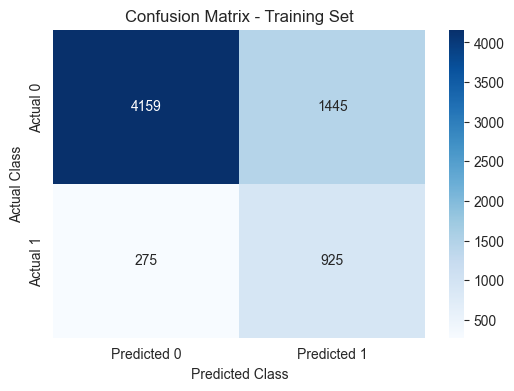


--- Model Performance on Test Set ---
AUC Score: 0.8057
KS Statistic: 0.4721

Metrics (using 0.5 decision threshold):

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.93      0.72      0.81      1401
     Class 1       0.36      0.74      0.49       300

    accuracy                           0.73      1701
   macro avg       0.65      0.73      0.65      1701
weighted avg       0.83      0.73      0.76      1701

Confusion Matrix:
[[1013  388]
 [  79  221]]


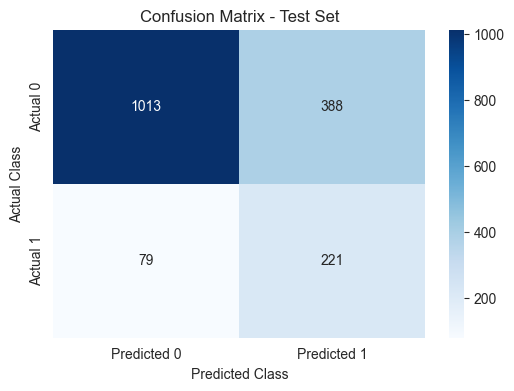


--- Generalization Check ---
Training AUC: 0.8347  |  Test AUC: 0.8057
Training KS:  0.5187  |  Test KS:  0.4721

AUC Difference (Train - Test): 0.0290
KS Difference (Train - Test):  0.0466

Result: Good generalization!
The model performs similarly on both training and test data.
This is the ideal outcome.


In [240]:

def evaluate_model_performance(model, X, y_true, set_name="Test"):
    """
    Calculates and prints a comprehensive performance report for a binary classifier.
    
    Args:
        model: The fitted (and pre-processing) pipeline.
        X: The feature DataFrame (raw).
        y_true: The true labels (0 or 1).
        set_name: A string name for the dataset (e.g., "Training" or "Test").
    """
    print(f"\n--- Model Performance on {set_name} Set ---")
    
    # 1. PROBABILITY-BASED METRICS (AUC & KS)
    # ------------------------------------------
    # Predict probabilities for the positive class (class 1)
    try:
        y_probs = model.predict_proba(X)[:, 1]
    except Exception as e:
        print(f"Error getting probabilities: {e}")
        print("Please ensure your 'X' data is the raw DataFrame for the pipeline.")
        return None

    # Calculate AUC
    auc = roc_auc_score(y_true, y_probs)
    print(f"AUC Score: {auc:.4f}")

    # Calculate KS Statistic
    probs_positive = y_probs[y_true == 1]
    probs_negative = y_probs[y_true == 0]
    
    ks_stat = 0.0
    if len(probs_positive) > 0 and len(probs_negative) > 0:
        ks_stat = ks_2samp(probs_positive, probs_negative).statistic
        print(f"KS Statistic: {ks_stat:.4f}")
    else:
        print("KS Statistic: Cannot compute (one class is missing in this dataset)")

    # 2. CLASS-BASED METRICS (Using 0.5 Threshold)
    # ---------------------------------------------
    # model.predict() automatically uses a 0.5 threshold to classify
    y_pred = model.predict(X)
    
    print(f"\nMetrics (using 0.5 decision threshold):")
    
   
    # Display Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

    # Display Confusion Matrix
    # 
    print("Confusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    # Plot the confusion matrix
    try:
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Predicted 0', 'Predicted 1'], 
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.title(f'Confusion Matrix - {set_name} Set')
        plt.ylabel('Actual Class')
        plt.xlabel('Predicted Class')
        plt.show()
    except Exception as e:
        print(f"Could not plot confusion matrix: {e}")
        
    return {"AUC": auc, "KS": ks_stat}


# --- SCRIPT EXECUTION ---

# 1. Get the best-tuned model from your grid search
# This 'best_model' is the ENTIRE pipeline (pre-processor + classifier)
# that performed best during cross-validation.
try:
    best_model = grid_search.best_estimator_
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best CV AUC score: {grid_search.best_score_:.4f}")

    # 2. Evaluate on TRAINING Set
    train_metrics = evaluate_model_performance(best_model, X_train, y_train, "Training")

    # 3. Evaluate on TEST Set
    test_metrics = evaluate_model_performance(best_model, X_test, y_test, "Test")

    # 4. Check for Generalization (Overfitting)
    if train_metrics and test_metrics:
        print("\n" + "="*30)
        print("--- Generalization Check ---")
        print("="*30)
        
        train_auc = train_metrics['AUC']
        test_auc = test_metrics['AUC']
        train_ks = train_metrics['KS']
        test_ks = test_metrics['KS']

        print(f"Training AUC: {train_auc:.4f}  |  Test AUC: {test_auc:.4f}")
        print(f"Training KS:  {train_ks:.4f}  |  Test KS:  {test_ks:.4f}")
        
        auc_diff = train_auc - test_auc
        ks_diff = train_ks - test_ks

        print(f"\nAUC Difference (Train - Test): {auc_diff:.4f}")
        print(f"KS Difference (Train - Test):  {ks_diff:.4f}")
        
        # 

        if auc_diff > 0.1:
            print("\nResult: High risk of OVERFITTING.")
            print("The model performs much better on the data it was trained on")
            print("than on new, unseen data. Re-check your parameters.")
        elif auc_diff > 0.03:
            print("\nResult: Slight overfitting may be present.")
            print("Performance is good, but noticeably worse on the test set.")
            print("This is common, but you may be able to improve it.")
        else:
            print("\nResult: Good generalization!")
            print("The model performs similarly on both training and test data.")
            print("This is the ideal outcome.")

except NameError as e:
    print(f"ERROR: A required variable is not defined: {e}")
    print("Please make sure 'grid_search', 'X_train', 'y_train', 'X_test', and 'y_test' exist.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    print("Please ensure your 'grid_search' object has been successfully fitted.")


In [241]:
columns_to_remove = [
    'sub_grade',             # Redundant with 'grade'
    'state',                 # Too granular, use 'region' instead
    'application_type',      # Usually not discriminative
    'issue_month',           # Time-specific, not customer characteristic
    'year', 'month',         # Time variables, not customer traits
    'loan_status',           # This is outcome, not input feature
    'initial_listing_status', # Platform-specific, not customer trait
    'disbursement_method',   # Operational, not customer characteristic
    'emp_category',          # Likely derived from emp_length
    'grade',
    'loan_grade_status',     # Seems derived/redundant
    
    # Payment history (outcome variables, not predictive features)
    'balance',
    'paid_total', 
    'paid_principal',
    'paid_interest',
    'paid_late_fees',
    
    # Very granular credit metrics (keep the most important ones)
    'earliest_credit_line',           # Use account age instead
    'months_since_90d_late',          # Keep months_since_last_delinq
    'num_collections_last_12m',       # Keep total_collection_amount_ever
    'months_since_last_credit_inquiry', # Keep inquiries_last_12m
    'num_accounts_120d_past_due',     # Keep 30d version
    'num_active_debit_accounts',      # Focus on credit accounts
    'total_debit_limit',              # Focus on credit metrics
    'num_total_cc_accounts',          # Keep open_credit_lines instead
    'num_open_cc_accounts',           # Redundant
    'num_cc_carrying_balance',        # Use utilization instead
    'num_mort_accounts',              # Not core to unsecured lending
    'tax_liens',                      # Very rare, not discriminative
    'current_installment_accounts',   # Not as important
    'accounts_opened_24m',            # Not as critical
    'num_satisfactory_accounts',      # Use delinq percent instead
    'num_historical_failed_to_pay',  # Use recent delinq instead,
]

In [242]:
# If columns_to_remove is a tuple/list/array of strings:
df_seg = df_seg.drop(columns=pd.Index(columns_to_remove).intersection(df_seg.columns))


In [243]:
'earliest_credit_line', 'num_collections_last_12m', 'num_historical_failed_to_pay', 'months_since_90d_late', 'current_installment_accounts', 'accounts_opened_24m', 'months_since_last_credit_inquiry', 'num_satisfactory_accounts', 'num_accounts_120d_past_due', 'num_active_debit_accounts', 'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts', 'num_cc_carrying_balance', 'num_mort_accounts', 'tax_liens', 'balance', 'paid_total', 'paid_principal', 'paid_interest', 'paid_late_fees'

('earliest_credit_line',
 'num_collections_last_12m',
 'num_historical_failed_to_pay',
 'months_since_90d_late',
 'current_installment_accounts',
 'accounts_opened_24m',
 'months_since_last_credit_inquiry',
 'num_satisfactory_accounts',
 'num_accounts_120d_past_due',
 'num_active_debit_accounts',
 'total_debit_limit',
 'num_total_cc_accounts',
 'num_open_cc_accounts',
 'num_cc_carrying_balance',
 'num_mort_accounts',
 'tax_liens',
 'balance',
 'paid_total',
 'paid_principal',
 'paid_interest',
 'paid_late_fees')

In [244]:
numeric_cols = [
    'emp_length', 'annual_income', 'debt_to_income', 'delinq_2y',
    'months_since_last_delinq', 'inquiries_last_12m',
    'total_credit_lines', 'open_credit_lines', 'total_credit_limit',
    'total_credit_utilized', 
    'current_accounts_delinq', 'total_collection_amount_ever',
    'num_accounts_30d_past_due',
    'account_never_delinq_percent', 'public_record_bankrupt',
    'loan_amount', 'term', 'interest_rate', 'installment',
    'amount_per_month'
]

df_num = df_seg[numeric_cols]



In [245]:
import numpy as np

#    Set your correlation threshold
threshold = 0.8

#    Compute the correlation matrix
corr_matrix = df_num.corr().abs()

#    Create an upper triangle matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

#    Find columns with correlation greater than the threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print(f"Columns to drop (correlation > {threshold}):")
print(to_drop)

#    Drop the highly correlated columns
df_num_reduced = df_num.drop(columns=to_drop)

print(f"\nReduced DataFrame shape: {df_num_reduced.shape}")


Columns to drop (correlation > 0.8):
['installment', 'amount_per_month']

Reduced DataFrame shape: (8505, 18)


In [246]:
# Drop the old numeric columns from the full dataframe
df_seg_reduced = df_seg.drop(columns=df_num.columns, errors='ignore')

# Add the reduced numeric columns back
df_seg_ = pd.concat([df_seg, df_num_reduced], axis=1)

print(f"✅ Final DataFrame shape: {df_seg.shape}")


✅ Final DataFrame shape: (8505, 24)


In [247]:
# Extract PD Scores from Both Train and Test Sets
print("Extracting PD Scores from Train and Test Sets")
print("="*60)

# Extract PD scores from both sets using the best model
if 'best_model' in locals():
    print(f"✅ Using best model: {type(best_model.named_steps['classifier']).__name__}")
    
    # Extract PD scores from training set
    pd_scores_train = best_model.predict_proba(X_train)[:, 1]
    
    # Extract PD scores from test set  
    pd_scores_test = best_model.predict_proba(X_test)[:, 1]
    
    print(f"\nPD Scores Extracted:")
    print(f"Train Set:")
    print(f"  - Shape: {pd_scores_train.shape}")
    print(f"  - Range: {pd_scores_train.min():.4f} to {pd_scores_train.max():.4f}")
    print(f"  - Mean: {pd_scores_train.mean():.4f}")
    
    print(f"Test Set:")
    print(f"  - Shape: {pd_scores_test.shape}")
    print(f"  - Range: {pd_scores_test.min():.4f} to {pd_scores_test.max():.4f}")
    print(f"  - Mean: {pd_scores_test.mean():.4f}")
    
    # Combine train and test indices and PD scores
    combined_indices = list(X_train.index) + list(X_test.index)
    pd_score = np.concatenate([pd_scores_train, pd_scores_test])
    combined_targets = np.concatenate([y_train.values, y_test.values])
    
    print(f"\nCombined Dataset:")
    print(f"  - Total samples: {len(combined_indices):,}")
    print(f"  - Train samples: {len(X_train):,}")
    print(f"  - Test samples: {len(X_test):,}")
    print(f"  - Combined PD range: {pd_score.min():.4f} to {pd_score.max():.4f}")
    
    # Create a dataframe to properly merge PD scores back to original data
    pd_results = pd.DataFrame({
        'index': combined_indices,
        'pd_score': pd_score,
        'actual_default': combined_targets,
        'data_split': ['train'] * len(X_train) + ['test'] * len(X_test)
    })
    
    print(f"\nPD Results DataFrame created:")
    print(f"  - Shape: {pd_results.shape}")
    print(f"  - Columns: {list(pd_results.columns)}")
    
    # Display sample
    print(f"\nSample PD Results:")
    display(pd_results.head())
    
    print(f"\n PD scores extracted and ready for segmentation analysis")
    
else:
    print(" ERROR: 'best_model' not found. Please run the grid search evaluation first.")

Extracting PD Scores from Train and Test Sets
✅ Using best model: LogisticRegression

PD Scores Extracted:
Train Set:
  - Shape: (6804,)
  - Range: 0.0006 to 0.9900
  - Mean: 0.3932
Test Set:
  - Shape: (1701,)
  - Range: 0.0033 to 0.9863
  - Mean: 0.4021

Combined Dataset:
  - Total samples: 8,505
  - Train samples: 6,804
  - Test samples: 1,701
  - Combined PD range: 0.0006 to 0.9900

PD Results DataFrame created:
  - Shape: (8505, 4)
  - Columns: ['index', 'pd_score', 'actual_default', 'data_split']

Sample PD Results:


,index,pd_score,actual_default,data_split
0,1239,0.617384,1,train
1,8437,0.275053,0,train
2,9727,0.418327,0,train
3,7158,0.081245,0,train
4,6990,0.592844,0,train



 PD scores extracted and ready for segmentation analysis


In [248]:

print("\nPreparing df_seg for K-means Clustering")
print("="*60)

if 'df_seg' in locals():
    
    # Show all available columns
    print(f"Available columns in df_seg ({len(df_seg.columns)}):")
    for i, col in enumerate(df_seg.columns, 1):
        print(f"  {i:2d}. {col}")
    
    # Define features for clustering (based on your column names)
    # Adjust these based on your actual column names
    numerical_features_clustering = [
        'pd_score',                    # From classification model
        'loan_amount',                 # Loan size
        'interest_rate',               # Return rate
        'annual_income',               # Income
        'debt_to_income',              # Debt ratio
        'installment',                 # Monthly payment
        'total_credit_limit',          # Credit capacity
        'total_credit_utilized',       # Credit usage
        'delinq_2y',                   # Recent delinquencies
        'inquiries_last_12m',          # Credit inquiries
        'open_credit_lines',           # Open accounts
        'total_credit_lines',          # Total accounts
        # Add other numerical columns you want to include
    ]
    
    categorical_features_clustering = [
        'homeownership',               # Home ownership
        'emp_length',                  # Employment length
        'verified_income',             # Income verification
        'loan_purpose',                # Loan purpose
        'term',                        # Loan term

        'region'                   # Geographic region
        # Add other categorical columns you want to include
    ]
    
    # Filter to existing columns
    existing_numerical = [col for col in numerical_features_clustering if col in df_seg.columns]
    existing_categorical = [col for col in categorical_features_clustering if col in df_seg.columns]
    
    print(f"\nFeatures selected for clustering:")
    print(f"  - Numerical features ({len(existing_numerical)}): {existing_numerical}")
    print(f"  - Categorical features ({len(existing_categorical)}): {existing_categorical}")
    
    # Create clustering subset
    all_clustering_features = existing_numerical + existing_categorical
    df_seg_clustering = df_seg[all_clustering_features].copy()
    
    print(f"\nFinal clustering dataset (df_seg_clustering):")
    print(f"  - Shape: {df_seg_clustering.shape}")
    print(f"  - Total features: {len(all_clustering_features)}")
    print(f"  - Includes PD scores: {'pd_score' in df_seg_clustering.columns}")
    
    # Check missing values
    missing_counts = df_seg_clustering.isnull().sum()
    high_missing = missing_counts[missing_counts > len(df_seg_clustering) * 0.1]
    
    if len(high_missing) > 0:
        print(f"\n  Features with >10% missing values:")
        for feature, count in high_missing.items():
            pct = (count / len(df_seg_clustering)) * 100
            print(f"    - {feature}: {pct:.1f}% missing")
    else:
        print(f"\n All features have <10% missing values")
    
    print(f"  1. Preprocessing (imputation + scaling + encoding)")
    print(f"  2. PCA for dimensionality reduction") 
    print(f"\nDataset: {len(df_seg_clustering):,} customers with {len(all_clustering_features)} features")
    
else:
    print(" df_seg not available. Please run the previous steps first.")


Preparing df_seg for K-means Clustering
Available columns in df_seg (24):
   1. emp_length
   2. homeownership
   3. annual_income
   4. verified_income
   5. debt_to_income
   6. delinq_2y
   7. months_since_last_delinq
   8. inquiries_last_12m
   9. total_credit_lines
  10. open_credit_lines
  11. total_credit_limit
  12. total_credit_utilized
  13. current_accounts_delinq
  14. total_collection_amount_ever
  15. num_accounts_30d_past_due
  16. account_never_delinq_percent
  17. public_record_bankrupt
  18. loan_purpose
  19. loan_amount
  20. term
  21. interest_rate
  22. installment
  23. region
  24. amount_per_month

Features selected for clustering:
  - Numerical features (11): ['loan_amount', 'interest_rate', 'annual_income', 'debt_to_income', 'installment', 'total_credit_limit', 'total_credit_utilized', 'delinq_2y', 'inquiries_last_12m', 'open_credit_lines', 'total_credit_lines']
  - Categorical features (6): ['homeownership', 'emp_length', 'verified_income', 'loan_purpose',

In [249]:
# # Add PD Scores to df_seg for Clustering
# print("\n🔄 ADDING PD SCORES TO SEGMENTATION DATASET")
# print("=" * 55)

# if 'pd_results' in locals() and 'df_seg' in locals():
    
#     print(f"Before merge:")
#     print(f"  - df_seg shape: {df_seg.shape}")
#     print(f"  - pd_results shape: {pd_results.shape}")
#     print(f"  - PD scores available: {len(pd_results)}")
    
#     # Reset index of df_seg to prepare for merge
#     df_seg_with_index = df_seg.reset_index()
    
#     # Merge PD scores back to df_seg based on original index
#     df_seg_merged = df_seg_with_index.merge(
#         pd_results[['index', 'pd_score', 'data_split']], 
#         left_on='index', 
#         right_on='index', 
#         how='left'
#     )
    
#     # Update df_seg with PD scores
#     df_seg = df_seg_merged.set_index('index')
    
#     print(f"\nAfter merge:")
#     print(f"  - df_seg shape: {df_seg.shape}")
#     print(f"  - PD scores added: {'pd_score' in df_seg.columns}")
    
#     if 'pd_score' in df_seg.columns:
#         pd_stats = df_seg['pd_score'].describe()
#         print(f"\nPD Score Statistics in df_seg:")
#         print(f"  - Count: {pd_stats['count']:.0f}")
#         print(f"  - Mean: {pd_stats['mean']:.4f}")
#         print(f"  - Std: {pd_stats['std']:.4f}")
#         print(f"  - Min: {pd_stats['min']:.4f}")
#         print(f"  - Max: {pd_stats['max']:.4f}")
        
#         # Check for missing PD scores
#         missing_pd = df_seg['pd_score'].isnull().sum()
#         if missing_pd > 0:
#             print(f"  - Missing PD scores: {missing_pd} ({missing_pd/len(df_seg)*100:.1f}%)")
#         else:
#             print(f"  ✅ No missing PD scores")
    
#     # Show sample with PD scores
#     print(f"\nSample of df_seg with PD scores:")
#     sample_cols = ['pd_score', 'data_split']
    
#     # Add a few other key columns if they exist
#     for col in ['loan_amount', 'annual_income', 'interest_rate', 'grade']:
#         if col in df_seg.columns:
#             sample_cols.append(col)
    
#     display(df_seg[sample_cols].head())
    
#     print(f"\n✅ PD scores successfully added to df_seg")
#     print(f"📊 df_seg is now ready for clgustering with PD scores")

# elif 'pd_results' not in locals():
#     print(" pd_results not found. Please run the PD extraction cell first.")
# elif 'df_seg' not in locals():
#     print(" df_seg not found. Please ensure the segmentation dataset is prepared.")
# else:
#     print(" Required variables not found.")
# # ============================================================
# # Robust preprocessing for numeric + categorical features
# # ============================================================

# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # --- Define expected numeric and categorical features ---
# expected_numeric = [
#     'emp_length', 'annual_income', 'debt_to_income', 'delinq_2y',
#     'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines',
#     'total_credit_limit', 'total_credit_utilized', 'current_accounts_delinq',
#     'total_collection_amount_ever', 'num_accounts_30d_past_due',
#     'account_never_delinq_percent', 'public_record_bankrupt',
#     'loan_amount', 'term', 'interest_rate', 'installment',
#     'amount_per_month', 'pd_score_x', 'pd_score_y'
# ]

# expected_categorical = [
#     'homeownership', 'verified_income', 'months_since_last_delinq',
#     'loan_purpose', 'region', 'data_split_x', 'data_split_y', 'data_split'
# ]

# # --- Keep only columns that exist in df ---
# numeric_features = [c for c in expected_numeric if c in df_seg.columns]
# categorical_features = [c for c in expected_categorical if c in df_seg.columns]

# print("Numeric features used:", numeric_features)
# print("Categorical features used:", categorical_features)

# # --- Drop PD scores to avoid leakage ---
# pd_like = [c for c in ['pd_score', 'pd_score_x', 'pd_score_y'] if c in df.columns]
# numeric_features = [c for c in numeric_features if c not in pd_like]

# # --- Define transformations ---
# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ]
# )

# # --- Apply transformations safely ---
# X_processed = preprocessor.fit_transform(df_seg)

# encoded_cat_names = []
# if categorical_features:
#     encoded_cat_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)

# feature_names = np.concatenate([numeric_features, encoded_cat_names])
# print(f"Final feature matrix shape after preprocessing: {X_processed.shape}")

# # ============================================================
# # PCA Dimensionality Reduction (Automatic selection)
# # ============================================================

# pca_full = PCA(random_state=42)
# pca_full.fit(X_processed)

# cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_) * 100

# plt.figure(figsize=(8, 5))
# plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
# plt.axhline(y=90, color='r', linestyle='--', label='90% threshold')
# plt.axhline(y=95, color='g', linestyle='--', label='95% threshold')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Explained Variance (%)')
# plt.title('Scree Plot: PCA Dimensionality Reduction')
# plt.legend()
# plt.grid(True)
# plt.show()

# # --- Select number of components explaining ≥90% variance ---
# n_components = np.argmax(cumulative_variance >= 90) + 1
# print(f"Number of components explaining ≥90% variance: {n_components}")

# pca = PCA(n_components=n_components, random_state=42)
# X_reduced = pca.fit_transform(X_processed)

# df_seg['PCA1'] = X_reduced[:, 0]
# df_seg['PCA2'] = X_reduced[:, 1]

# plt.figure(figsize=(6, 5))
# plt.scatter(df_seg['PCA1'], df_seg['PCA2'], alpha=0.5)
# plt.title('Borrower Distribution after PCA Reduction')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.grid(True)
# plt.show()

# print(f"Total variance explained by first {n_components} components: {cumulative_variance[n_components - 1]:.2f}%")

# wcss = []
# K_range = range(2, 11)  # Test between 2 and 10 clusters
# for k in K_range:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(X_reduced)
#     wcss.append(kmeans.inertia_)

# plt.figure(figsize=(8, 5))
# plt.plot(K_range, wcss, marker='o')
# plt.title("Elbow Method for Optimal k")
# plt.xlabel("Number of Clusters (k)")
# plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
# plt.grid(True)
# plt.show()

# # --- Choose optimal k manually after visual inspection ---
# optimal_k = 4  # Adjust this after checking the Elbow chart
# print(f"Using optimal number of clusters: {optimal_k}")
# # ============================================================
# # Step 3: Fit Final KMeans Model
# # ============================================================

# kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
# cluster_labels = kmeans_final.fit_predict(X_reduced)
# df_seg['cluster'] = cluster_labels

# # Add cluster centers (in PCA space) for visualization
# centers = kmeans_final.cluster_centers_

# plt.figure(figsize=(7, 6))
# plt.scatter(df_seg['PCA1'], df_seg['PCA2'], c=df_seg['cluster'], cmap='viridis', alpha=0.5)
# plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label='Cluster Centers')
# plt.title("K-Means Clustering of Borrowers (PCA-Reduced Space)")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.legend()
# plt.grid(True)
# plt.show()

# #============================================================
# # Step 4: Analyze and Label Cluster Risk Levels
# # ============================================================

# # Determine which PD column exists for risk mapping
# pd_column = None
# for col in ['pd_score', 'pd_score_x', 'pd_score_y']:
#     if col in df_seg.columns:
#         pd_column = col
#         break

# if pd_column:
#     cluster_summary = df_seg.groupby('cluster')[pd_column].agg(['mean', 'count']).reset_index()
#     cluster_summary = cluster_summary.sort_values('mean')
#     cluster_summary['risk_level'] = ['Low', 'Moderate', 'High', 'Very High'][:len(cluster_summary)]
#     print("\nCluster Summary (sorted by average PD):")
#     print(cluster_summary)
    
#     # Map risk levels back to df_seg
#     risk_map = dict(zip(cluster_summary['cluster'], cluster_summary['risk_level']))
#     df_seg['risk_level'] = df_seg['cluster'].map(risk_map)
# else:
#     print("No PD score column found; skipping risk label creation.")

# # ============================================================
# # Step 5: Save results
# # ============================================================

# df_seg.to_csv("borrower_clusters.csv", index=False)
# print("\nBorrower segmentation complete. File saved as 'borrower_clusters.csv'.")


🔄 ADDING PD SCORES TO SEGMENTATION DATASET
Before merge:
  - df_seg shape: (8505, 24)
  - pd_results shape: (8505, 4)

After merge:
  - df_seg shape: (8505, 26)
  - PD score present: True

PD Score Summary:
  Count     : 8505.0000
  Mean      : 0.3950
  Std       : 0.2700
  Min       : 0.0006
  25%       : 0.1578
  50%       : 0.3509
  75%       : 0.6103
  Max       : 0.9900
  Missing: 0


,pd_score,data_split
index,,
0,0.913967,train
1,0.128133,train
2,0.876107,train
3,0.126986,train
5,0.039887,test



⚙️ Building preprocessing pipeline (excluding PD score from PCA)
Numeric features used: ['emp_length', 'annual_income', 'debt_to_income', 'delinq_2y', 'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines', 'total_credit_limit', 'total_credit_utilized', 'current_accounts_delinq', 'total_collection_amount_ever', 'num_accounts_30d_past_due', 'account_never_delinq_percent', 'public_record_bankrupt', 'loan_amount', 'term', 'interest_rate', 'installment', 'amount_per_month']
Categorical features used: ['homeownership', 'verified_income', 'months_since_last_delinq', 'loan_purpose', 'region']
✅ Feature matrix shape: (8505, 128)


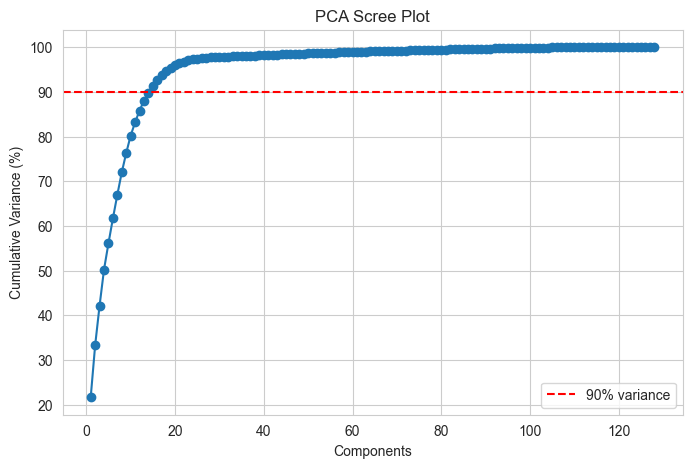

Selected components: 15
Variance explained by 15 components: 91.21%

🧩 Combining PCA features with PD score for clustering
Final clustering matrix shape: (8505, 16)


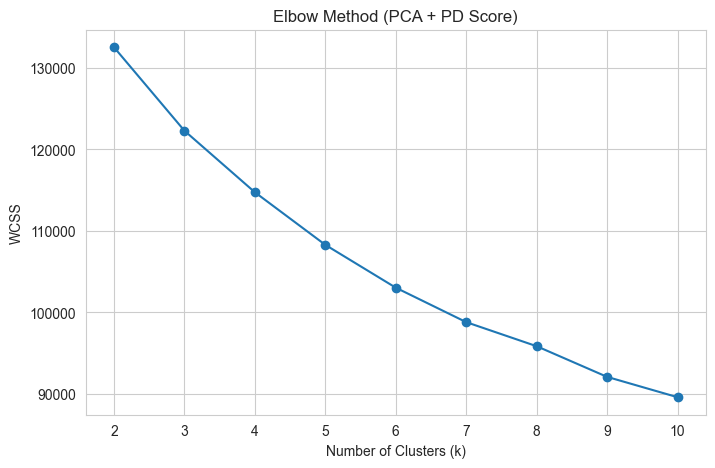

✅ Using optimal k = 4


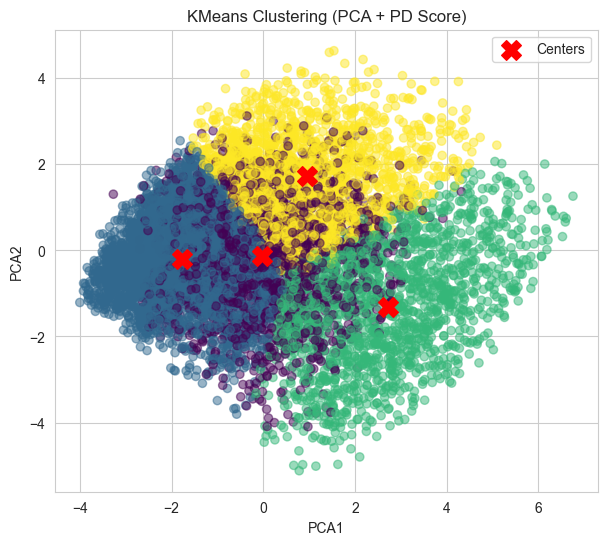


Cluster Summary by PD score:


,cluster,mean,count,risk_level
2,2,0.285837,1574,Low
3,3,0.299633,1724,Moderate
1,1,0.310704,3308,High
0,0,0.718722,1899,Very High



💾 Segmentation complete: 'borrower_clusters_with_pd.csv' saved.


In [250]:
# ============================================================
# STEP 1: Add PD Scores to Segmentation Dataset
# ============================================================
print("\n🔄 ADDING PD SCORES TO SEGMENTATION DATASET")
print("=" * 55)

if 'pd_results' in locals() and 'df_seg' in locals():

    print(f"Before merge:")
    print(f"  - df_seg shape: {df_seg.shape}")
    print(f"  - pd_results shape: {pd_results.shape}")

    # Reset index of df_seg for merging
    df_seg_reset = df_seg.reset_index()

    # Merge PD scores and data_split back
    df_seg = df_seg_reset.merge(
        pd_results[['index', 'pd_score', 'data_split']],
        on='index', how='left'
    ).set_index('index')

    print(f"\nAfter merge:")
    print(f"  - df_seg shape: {df_seg.shape}")
    print(f"  - PD score present: {'pd_score' in df_seg.columns}")

    # Basic stats
    if 'pd_score' in df_seg.columns:
        stats = df_seg['pd_score'].describe()
        print(f"\nPD Score Summary:")
        for stat, val in stats.items():
            print(f"  {stat.capitalize():<10}: {val:.4f}")
        print(f"  Missing: {df_seg['pd_score'].isna().sum()}")

    display(df_seg[['pd_score', 'data_split']].head())

else:
    raise ValueError("Missing df_seg or pd_results. Ensure both are loaded.")


# ============================================================
# STEP 2: Preprocessing (Exclude PD from PCA)
# ============================================================
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

print("\n⚙️ Building preprocessing pipeline (excluding PD score from PCA)")

# Expected columns
expected_numeric = [
    'emp_length', 'annual_income', 'debt_to_income', 'delinq_2y',
    'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines',
    'total_credit_limit', 'total_credit_utilized', 'current_accounts_delinq',
    'total_collection_amount_ever', 'num_accounts_30d_past_due',
    'account_never_delinq_percent', 'public_record_bankrupt',
    'loan_amount', 'term', 'interest_rate', 'installment',
    'amount_per_month'
]

expected_categorical = [
    'homeownership', 'verified_income', 'months_since_last_delinq',
    'loan_purpose', 'region'
]

# Filter only existing
numeric_features = [c for c in expected_numeric if c in df_seg.columns]
categorical_features = [c for c in expected_categorical if c in df_seg.columns]

print("Numeric features used:", numeric_features)
print("Categorical features used:", categorical_features)

# Define transformations
num_pipe = Pipeline([('scaler', StandardScaler())])
cat_pipe = Pipeline([('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_features),
    ('cat', cat_pipe, categorical_features)
])

# Apply transformation
X_processed = preprocessor.fit_transform(df_seg)

# Feature names
encoded_names = []
if categorical_features:
    encoded_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, encoded_names])

print(f"✅ Feature matrix shape: {X_processed.shape}")

# ============================================================
# STEP 3: PCA on borrower features (excluding PD)
# ============================================================
pca_full = PCA(random_state=42)
pca_full.fit(X_processed)

cumulative_var = np.cumsum(pca_full.explained_variance_ratio_) * 100

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o')
plt.axhline(90, color='r', linestyle='--', label='90% variance')
plt.xlabel('Components')
plt.ylabel('Cumulative Variance (%)')
plt.title('PCA Scree Plot')
plt.legend()
plt.grid(True)
plt.show()

# Choose minimum components explaining ≥90%
n_components = np.argmax(cumulative_var >= 90) + 1
print(f"Selected components: {n_components}")

pca = PCA(n_components=n_components, random_state=42)
X_reduced = pca.fit_transform(X_processed)

df_seg['PCA1'] = X_reduced[:, 0]
df_seg['PCA2'] = X_reduced[:, 1]
print(f"Variance explained by {n_components} components: {cumulative_var[n_components-1]:.2f}%")

# ============================================================
# STEP 4: Combine PCA + PD score for KMeans clustering
# ============================================================
print("\n🧩 Combining PCA features with PD score for clustering")

if 'pd_score' not in df_seg.columns:
    raise ValueError("PD score missing — cannot include in clustering.")

# Standardize PD score separately
pd_scaled = StandardScaler().fit_transform(df_seg[['pd_score']])
X_cluster = np.hstack([X_reduced, pd_scaled])

print(f"Final clustering matrix shape: {X_cluster.shape}")

# ============================================================
# STEP 5: Elbow Method
# ============================================================
wcss = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_cluster)
    wcss.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.title("Elbow Method (PCA + PD Score)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

optimal_k = 4  # Adjust based on elbow chart
print(f"✅ Using optimal k = {optimal_k}")

# ============================================================
# STEP 6: Final Clustering and Risk Mapping
# ============================================================
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_seg['cluster'] = kmeans_final.fit_predict(X_cluster)

# Visualize PCA plane (PD not plotted)
plt.figure(figsize=(7, 6))
plt.scatter(df_seg['PCA1'], df_seg['PCA2'], c=df_seg['cluster'], cmap='viridis', alpha=0.5)
plt.scatter(kmeans_final.cluster_centers_[:, 0], kmeans_final.cluster_centers_[:, 1],
            c='red', s=200, marker='X', label='Centers')
plt.title("KMeans Clustering (PCA + PD Score)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()

# Cluster risk summary (by PD)
summary = df_seg.groupby('cluster')['pd_score'].agg(['mean', 'count']).reset_index()
summary = summary.sort_values('mean')
summary['risk_level'] = ['Low', 'Moderate', 'High', 'Very High'][:len(summary)]
print("\nCluster Summary by PD score:")
display(summary)

risk_map = dict(zip(summary['cluster'], summary['risk_level']))
df_seg['risk_level'] = df_seg['cluster'].map(risk_map)

# ============================================================
# STEP 7: Save output
# ============================================================
df_seg.to_csv("borrower_clusters_with_pd.csv", index=False)
print("\n💾 Segmentation complete: 'borrower_clusters_with_pd.csv' saved.")



🔍 Running Gaussian Mixture Model (GMM) for borrower segmentation
Final clustering dataset shape: (8505, 16)
Evaluating GMM models for components 2–10...


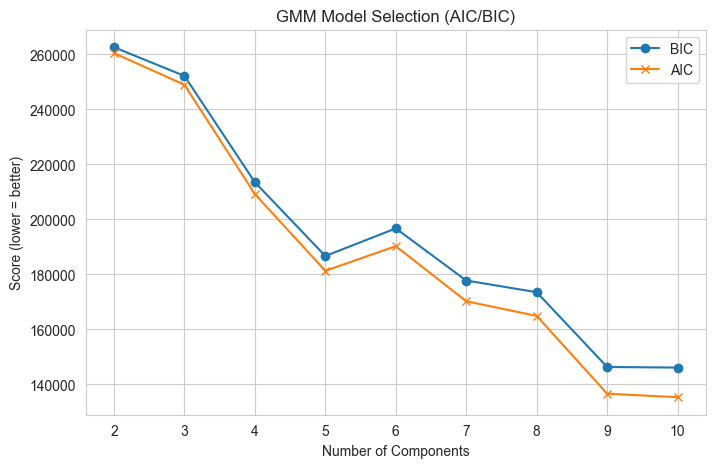

✅ Optimal number of GMM components (lowest BIC): 10

📊 GMM Key Performance Metrics:
  - AIC (lower = better): 135346.56
  - BIC (lower = better): 146123.58
  - Avg Log-Likelihood (higher = better): -7.7771

📊 GMM Key Performance Metrics:
  - AIC (lower = better): 135346.56
  - BIC (lower = better): 146123.58
  - Avg Log-Likelihood (higher = better): -7.7771


ValueError: Length of values (4) does not match length of index (10)

In [251]:
# ============================================================
# STEP 6: Gaussian Mixture Model (GMM) Clustering (PCA + PD)
# ============================================================
print("\n🔍 Running Gaussian Mixture Model (GMM) for borrower segmentation")
print("=" * 65)

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Sanity checks ---
if 'X_reduced' not in locals() or 'df_seg' not in locals() or 'pd_score' not in df_seg.columns:
    raise ValueError("Ensure PCA output and PD scores are available before running GMM.")

# --- Combine PCA features + scaled PD score ---
pd_scaled = StandardScaler().fit_transform(df_seg[['pd_score']])
X_cluster = np.hstack([X_reduced, pd_scaled])

print(f"Final clustering dataset shape: {X_cluster.shape}")

# ============================================================
# Model selection using AIC/BIC
# ============================================================
bic_scores, aic_scores = [], []
components_range = range(2, 11)

print("Evaluating GMM models for components 2–10...")

for k in components_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_cluster)
    bic_scores.append(gmm.bic(X_cluster))
    aic_scores.append(gmm.aic(X_cluster))

plt.figure(figsize=(8, 5))
plt.plot(components_range, bic_scores, marker='o', label='BIC')
plt.plot(components_range, aic_scores, marker='x', label='AIC')
plt.title("GMM Model Selection (AIC/BIC)")
plt.xlabel("Number of Components")
plt.ylabel("Score (lower = better)")
plt.legend()
plt.grid(True)
plt.show()

# --- Choose optimal k based on lowest BIC ---
optimal_k_gmm = components_range[np.argmin(bic_scores)]
print(f"✅ Optimal number of GMM components (lowest BIC): {optimal_k_gmm}")

# ============================================================
# Fit final GMM and compute key metrics
# ============================================================
final_gmm = GaussianMixture(n_components=optimal_k_gmm, covariance_type='full', random_state=42)
final_gmm.fit(X_cluster)

df_seg['gmm_cluster'] = final_gmm.predict(X_cluster)
df_seg['assignment_confidence'] = final_gmm.predict_proba(X_cluster).max(axis=1)

aic_final = final_gmm.aic(X_cluster)
bic_final = final_gmm.bic(X_cluster)
avg_loglike = final_gmm.score(X_cluster)

print("\n📊 GMM Key Performance Metrics:")
print(f"  - AIC (lower = better): {aic_final:.2f}")
print(f"  - BIC (lower = better): {bic_final:.2f}")
print(f"  - Avg Log-Likelihood (higher = better): {avg_loglike:.4f}")

# ============================================================
# Cluster Risk Summary
# ============================================================
cluster_summary = (
    df_seg.groupby('gmm_cluster')['pd_score']
    .agg(['mean', 'count'])
    .reset_index()
    .sort_values('mean')
)
cluster_summary['risk_level'] = ['Low', 'Moderate', 'High', 'Very High'][:len(cluster_summary)]

print("\n📈 GMM Cluster Summary (sorted by average PD):")
display(cluster_summary)

# Map risk levels back to main dataframe
risk_map = dict(zip(cluster_summary['gmm_cluster'], cluster_summary['risk_level']))
df_seg['gmm_risk_level'] = df_seg['gmm_cluster'].map(risk_map)

# ============================================================
# Visualize GMM Clusters (PCA plane only)
# ============================================================
plt.figure(figsize=(7, 6))
plt.scatter(df_seg['PCA1'], df_seg['PCA2'], c=df_seg['gmm_cluster'], cmap='viridis', alpha=0.5)
plt.title("GMM Borrower Clustering (PCA + PD Score)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# ============================================================
# Save final dataset
# ============================================================
df_seg.to_csv("borrower_clusters_gmm_major_metrics.csv", index=False)
print("\n💾 GMM segmentation complete — saved as 'borrower_clusters_gmm_major_metrics.csv'.")



🔍 Running Gaussian Mixture Model (GMM) for borrower segmentation
✅ Final clustering dataset shape: (8505, 16)
Evaluating GMM models for components 2–10...


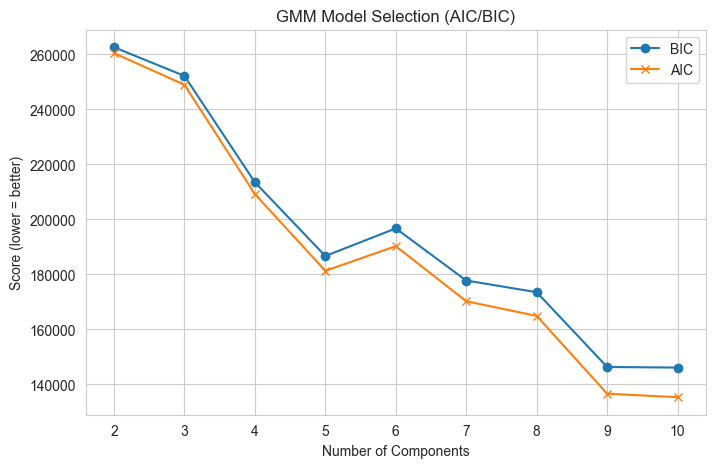

✅ Optimal number of GMM components (lowest BIC): 10

📊 GMM Key Performance Metrics:
  - AIC (lower = better): 135346.56
  - BIC (lower = better): 146123.58
  - Avg Log-Likelihood (higher = better): -7.7771

📈 GMM Cluster Summary (sorted by average PD):

📊 GMM Key Performance Metrics:
  - AIC (lower = better): 135346.56
  - BIC (lower = better): 146123.58
  - Avg Log-Likelihood (higher = better): -7.7771

📈 GMM Cluster Summary (sorted by average PD):


,gmm_cluster,mean,count,risk_level
6,6,0.236076,1980,Very Low
2,2,0.308428,24,Low
0,0,0.339937,865,Moderate
9,9,0.355924,161,Elevated
8,8,0.370827,195,High
7,7,0.376199,1661,Very High
3,3,0.394341,940,Severe
5,5,0.421906,778,Critical
1,1,0.584041,1550,Extreme
4,4,0.659804,351,Maximum


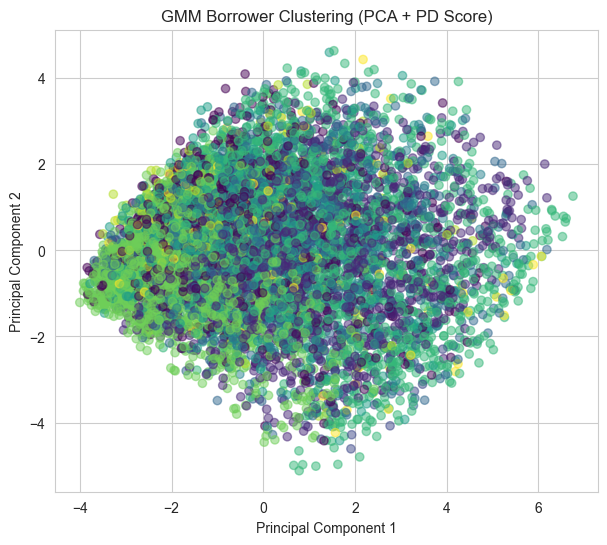


💾 GMM segmentation complete — saved as 'borrower_clusters_gmm_major_metrics.csv'
Columns added: ['gmm_cluster', 'assignment_confidence', 'gmm_risk_level']


In [252]:
# ============================================================
# STEP 6: Gaussian Mixture Model (GMM) Clustering (PCA + PD)
# ============================================================

print("\n🔍 Running Gaussian Mixture Model (GMM) for borrower segmentation")
print("=" * 70)

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Safety checks ---
if 'X_reduced' not in locals() or 'df_seg' not in locals() or 'pd_score' not in df_seg.columns:
    raise ValueError("Ensure PCA output and PD scores are available before running GMM.")

# ============================================================
# Combine PCA components + scaled PD score for clustering
# ============================================================
pd_scaled = StandardScaler().fit_transform(df_seg[['pd_score']])
X_cluster = np.hstack([X_reduced, pd_scaled])

print(f"✅ Final clustering dataset shape: {X_cluster.shape}")

# ============================================================
# Model Selection using AIC and BIC
# ============================================================
bic_scores, aic_scores = [], []
components_range = range(2, 11)

print("Evaluating GMM models for components 2–10...")

for k in components_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(X_cluster)
    bic_scores.append(gmm.bic(X_cluster))
    aic_scores.append(gmm.aic(X_cluster))

# --- Plot AIC/BIC curves ---
plt.figure(figsize=(8, 5))
plt.plot(components_range, bic_scores, marker='o', label='BIC')
plt.plot(components_range, aic_scores, marker='x', label='AIC')
plt.title("GMM Model Selection (AIC/BIC)")
plt.xlabel("Number of Components")
plt.ylabel("Score (lower = better)")
plt.legend()
plt.grid(True)
plt.show()

# --- Select optimal number of clusters based on lowest BIC ---
optimal_k_gmm = components_range[np.argmin(bic_scores)]
print(f"✅ Optimal number of GMM components (lowest BIC): {optimal_k_gmm}")

# ============================================================
# Fit Final GMM
# ============================================================
final_gmm = GaussianMixture(n_components=optimal_k_gmm, covariance_type='full', random_state=42)
final_gmm.fit(X_cluster)

# Assign clusters and confidence
df_seg['gmm_cluster'] = final_gmm.predict(X_cluster)
df_seg['assignment_confidence'] = final_gmm.predict_proba(X_cluster).max(axis=1)

# Compute key metrics
aic_final = final_gmm.aic(X_cluster)
bic_final = final_gmm.bic(X_cluster)
avg_loglike = final_gmm.score(X_cluster)

print("\n📊 GMM Key Performance Metrics:")
print(f"  - AIC (lower = better): {aic_final:.2f}")
print(f"  - BIC (lower = better): {bic_final:.2f}")
print(f"  - Avg Log-Likelihood (higher = better): {avg_loglike:.4f}")

# ============================================================
# Cluster Risk Summary (Automatic Label Scaling)
# ============================================================

cluster_summary = (
    df_seg.groupby('gmm_cluster')['pd_score']
    .agg(['mean', 'count'])
    .reset_index()
    .sort_values('mean')
)

# Automatically assign risk levels across available clusters
risk_labels = ['Very Low', 'Low', 'Moderate', 'Elevated', 'High',
               'Very High', 'Severe', 'Critical', 'Extreme', 'Maximum']

# Adjust label list to match cluster count
cluster_summary['risk_level'] = risk_labels[:len(cluster_summary)]

print("\n📈 GMM Cluster Summary (sorted by average PD):")
display(cluster_summary)

# Map risk levels back to df_seg
risk_map = dict(zip(cluster_summary['gmm_cluster'], cluster_summary['risk_level']))
df_seg['gmm_risk_level'] = df_seg['gmm_cluster'].map(risk_map)

# ============================================================
# Visualize GMM Clusters (2D PCA projection)
# ============================================================
plt.figure(figsize=(7, 6))
plt.scatter(df_seg['PCA1'], df_seg['PCA2'], c=df_seg['gmm_cluster'], cmap='viridis', alpha=0.5)
plt.title("GMM Borrower Clustering (PCA + PD Score)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

# ============================================================
# Save final dataset with GMM segmentation
# ============================================================
output_path = "borrower_clusters_gmm_major_metrics.csv"
df_seg.to_csv(output_path, index=False)

print(f"\n💾 GMM segmentation complete — saved as '{output_path}'")
print("Columns added: ['gmm_cluster', 'assignment_confidence', 'gmm_risk_level']")
